### STL Classification - Complete Metric Calculator
### Workflow:
1. **Function Definition** - Define the metrics to be calculated
2. **Test Function** - Verify implementation works correctly  
3. **Process All STL Files** - Generate CSV with all metrics
4. **Merge with Ground Truth** - Combine metrics with classification labels
5. **Classification Analysis** - Evaluate feature importance and accuracy

This notebook calculates **23 geometric metrics** for STL model classification (FLAT vs FREE FORM):
1. Bounding Box Ratio  
2. Aligned Ratio  
3. Normal Alignment (Mean & Std)  
4. Height Ratio  
5. Z-Variation (Normalized)  
6. Normal Variation  
7. Planarity Dominance
8. Aspect Ratio  
9. Eigenvalue Ratio (PCA)  
10. Z-Ratio (PCA)  
11. Normalized RMS Distance to Plane  
12. Surface Complexity
13. Overhang Fraction
14. Max Overhang Angle
15. Mean Overhang Angle
16. Face Density
17. Volume Efficiency  
**Gaussian Curvature Metrics (5):**
18. Gaussian Curvature Mean
19. Gaussian Curvature Standard Deviation  
20. Gaussian Curvature Maximum
21. Gaussian Curvature Minimum
22. Gaussian Curvature Range

**Notes on Gaussian Curvature Implementation (PyVista → Quadric Fitting)**
- Removed the previous PyVista-based curvature pipeline and replaced it with a two‑ring quadric fitting method inspired by Gatzke & Grimm (2006).  
- Why this change:
    - Eliminates PyVista dependency — the notebook now runs with trimesh, numpy and standard scientific stack.
    - Two‑ring quadric fitting produces more accurate local Gaussian curvature estimates on triangular meshes than simple angle‑deficit methods.
    - Added vertex sampling and outlier filtering for robust, faster computation on large meshes.
- Key implementation highlights:
    - Build per‑vertex two‑ring neighborhoods and fit a local quadric z = ax² + bxy + cy² + dx + ey + f in a PCA‑aligned local frame.
    - Compute Gaussian curvature from fitted quadric (K = 4ac − b²) for sampled vertices.
    - Aggregate statistics (mean, std, min, max, range) and filter extreme outliers before reporting.
- Result: accurate Gaussian curvature metrics (no PyVista) that are reproducible and performant for STL classification workflows.

Reference: Gatzke, T., & Grimm, C. (2006). Estimating curvature on triangular meshes.

In [5]:
import numpy as np
import trimesh


In [6]:

def compute_metrics_clean(mesh):
    """
    Compute all STL classification metrics using only angle deficit method for Gaussian curvature.
    No PyVista dependencies.
    """
    # Bounding Box Ratio
    extents = mesh.bounding_box.extents
    min_dim = min(extents)
    max_dim = max(extents)
    bbox_ratio = min_dim / max_dim if max_dim > 0 else 0

    # Height Ratio
    height_ratio = extents[2] / max(extents[0], extents[1], 1e-9)

    # Z-Variation (Normalized)
    z_coords = mesh.vertices[:, 2]
    z_std = np.std(z_coords)
    z_range = np.max(z_coords) - np.min(z_coords)
    z_std_normalized = z_std / z_range if z_range > 0 else 0

    # Face normals
    normals = mesh.face_normals
    avg_normal = np.mean(normals, axis=0)
    norm = np.linalg.norm(avg_normal)
    if norm > 0:
        avg_normal /= norm
    else:
        avg_normal = np.array([0, 0, 1])
    alignment = np.dot(normals, avg_normal)

    # Aligned Ratio
    aligned_ratio = np.mean(alignment > 0.9)

    # Normal Alignment (Dot Product)
    normal_alignment_mean = np.mean(alignment)
    normal_alignment_std = np.std(alignment)

    # Normal Variation
    normal_variation = np.mean(np.std(normals, axis=0))

    # Planarity Dominance (spherical binning)
    def planarity_dominance(normals, bin_degrees=15.0):
        norms = np.linalg.norm(normals, axis=1)
        normals = normals / (norms[:, None] + 1e-12)
        mask = (normals[:, 0] < 0) | ((normals[:, 0] == 0) & (normals[:, 1] < 0)) | ((normals[:, 0] == 0) & (normals[:, 1] == 0) & (normals[:, 2] < 0))
        normals[mask] = -normals[mask]
        theta = np.arccos(np.clip(normals[:, 2], -1.0, 1.0))
        phi = np.arctan2(normals[:, 1], normals[:, 0])
        phi = np.where(phi < 0, phi + 2*np.pi, phi)
        d = np.deg2rad(bin_degrees)
        nbins_theta = max(1, int(np.ceil(np.pi / d)))
        nbins_phi = max(1, int(np.ceil(2*np.pi / d)))
        btheta = np.minimum((theta / d).astype(np.int32), nbins_theta - 1)
        bphi = np.minimum((phi / d).astype(np.int32), nbins_phi - 1)
        keys = (btheta.astype(np.int64) * nbins_phi) + bphi.astype(np.int64)
        uniq, counts = np.unique(keys, return_counts=True)
        return counts.max() / counts.sum() if counts.size else 0.0
    planarity_dom = planarity_dominance(normals)

    # Aspect Ratio
    width, depth, height = extents
    aspect_ratio = max(height / (width + 1e-9), height / (depth + 1e-9))

    # PCA Eigenvalue Ratio
    vertices = mesh.vertices
    centroid = vertices.mean(axis=0)
    centered_vertices = vertices - centroid
    cov = np.cov(centered_vertices.T)
    eigenvalues, _ = np.linalg.eigh(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigen_sum = np.sum(eigenvalues)
    eigen_ratio = (eigenvalues[-1] / eigen_sum) if eigen_sum > 0 else 0

    # Z-Ratio (PCA)
    z_ratio_pca = extents[2] / max(extents[0], extents[1], 1e-9)

    # Normalized RMS Distance to Plane
    from numpy.linalg import svd
    _, _, vT = svd(centered_vertices, full_matrices=False)
    plane_normal = vT[-1]
    distances = np.abs(np.dot(centered_vertices, plane_normal))
    bbox_diag = np.linalg.norm(extents)
    rms_plane = np.sqrt(np.mean(distances ** 2))
    normalized_rms = rms_plane / (bbox_diag + 1e-9)

    # --- Surface Complexity ---
    n_faces = len(mesh.faces)
    surface_area = mesh.area if mesh.area > 0 else 1e-9
    surface_complexity = n_faces / surface_area

    # --- Overhang Analysis Metrics ---
    z_axis = np.array([0, 0, 1])
    face_dot_z = np.dot(mesh.face_normals, z_axis)
    face_dot_z = np.clip(face_dot_z, -1.0, 1.0)
    overhang_angle = np.arccos(face_dot_z) * 180 / np.pi
    overhang_thresh = 45  # degrees
    overhang_fraction = np.mean(overhang_angle > overhang_thresh)
    max_overhang_angle = np.max(overhang_angle)
    mean_overhang_angle = np.mean(overhang_angle)

    # --- Face Density ---
    bbox_volume = np.prod(extents) if np.all(extents > 0) else 1e-9
    face_density = n_faces / bbox_volume

    # --- Volume Efficiency ---
    mesh_volume = mesh.volume if hasattr(mesh, 'volume') and mesh.volume > 0 else 0
    volume_efficiency = mesh_volume / bbox_volume if bbox_volume > 0 else 0

    # --- Gaussian Curvature (Two-Ring Quadric Fitting) ---
    # Based on Gatzke & Grimm 2006: "Estimating Curvature on Triangular Meshes"
    # Uses two-ring quadric fitting with natural parameterization for better accuracy
    try:
        vertices = mesh.vertices
        faces = mesh.faces
        gaussian_curvatures = []
        
        # Build adjacency structure for efficient neighbor finding
        vertex_faces_dict = {}
        for face_idx, face in enumerate(faces):
            for vertex_idx in face:
                if vertex_idx not in vertex_faces_dict:
                    vertex_faces_dict[vertex_idx] = []
                vertex_faces_dict[vertex_idx].append(face_idx)
        
        # Sample vertices for reasonable computation time
        n_vertices = len(vertices)
        sample_size = min(300, n_vertices)  # Reduced sample for quadric fitting
        np.random.seed(42)  # For reproducible results
        vertex_indices = np.random.choice(n_vertices, sample_size, replace=False)
        
        def get_two_ring_neighbors(center_vertex, vertex_faces_dict, faces):
            """Get two-ring neighborhood vertices around center vertex"""
            one_ring = set()
            two_ring = set()
            
            # Get one-ring neighbors
            if center_vertex in vertex_faces_dict:
                for face_idx in vertex_faces_dict[center_vertex]:
                    face = faces[face_idx]
                    for v in face:
                        if v != center_vertex:
                            one_ring.add(v)
            
            # Get two-ring neighbors
            for v in one_ring:
                if v in vertex_faces_dict:
                    for face_idx in vertex_faces_dict[v]:
                        face = faces[face_idx]
                        for vv in face:
                            if vv != center_vertex and vv not in one_ring:
                                two_ring.add(vv)
            
            return list(one_ring), list(two_ring)
        
        def fit_quadric_surface(center_pos, neighbor_positions):
            """Fit quadric surface z = ax² + bxy + cy² + dx + ey + f to neighborhood"""
            if len(neighbor_positions) < 6:  # Need at least 6 points for quadric
                return None
                
            # Create local coordinate system with center as origin
            points = np.array(neighbor_positions) - center_pos
            
            # Use PCA to find local coordinate system
            if len(points) < 3:
                return None
            
            try:
                # Compute covariance matrix
                cov_matrix = np.cov(points.T)
                eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
                
                # Sort by eigenvalues (largest first)
                idx = np.argsort(eigenvalues)[::-1]
                eigenvectors = eigenvectors[:, idx]
                
                # Local coordinate system: z-axis is smallest principal component
                local_z = eigenvectors[:, 2]
                local_x = eigenvectors[:, 0]
                local_y = eigenvectors[:, 1]
                
                # Ensure right-handed coordinate system
                if np.dot(np.cross(local_x, local_y), local_z) < 0:
                    local_z = -local_z
                
                # Transform points to local coordinate system
                local_coords = np.zeros_like(points)
                for i, point in enumerate(points):
                    local_coords[i, 0] = np.dot(point, local_x)
                    local_coords[i, 1] = np.dot(point, local_y)
                    local_coords[i, 2] = np.dot(point, local_z)
                
                # Set up quadric fitting: z = ax² + bxy + cy² + dx + ey + f
                x, y, z = local_coords[:, 0], local_coords[:, 1], local_coords[:, 2]
                
                # Design matrix A for least squares
                A = np.column_stack([
                    x**2,    # a coefficient
                    x*y,     # b coefficient  
                    y**2,    # c coefficient
                    x,       # d coefficient
                    y,       # e coefficient
                    np.ones(len(x))  # f coefficient
                ])
                
                # Solve Ax = z using least squares
                try:
                    coeffs, residuals, rank, s = np.linalg.lstsq(A, z, rcond=None)
                    
                    if len(coeffs) == 6:
                        # Extract quadric coefficients: z = ax² + bxy + cy² + dx + ey + f
                        a, b, c, d, e, f = coeffs
                        
                        # Gaussian curvature K = 4ac - b² (for quadric z = ax² + bxy + cy²)
                        # This is the determinant of the Hessian matrix
                        gaussian_k = 4 * a * c - b**2
                        
                        return gaussian_k
                    
                except np.linalg.LinAlgError:
                    return None
                    
            except (np.linalg.LinAlgError, ValueError):
                return None
            
            return None
        
        # Process sampled vertices
        for v_idx in vertex_indices:
            try:
                center_pos = vertices[v_idx]
                
                # Get two-ring neighborhood
                one_ring, two_ring = get_two_ring_neighbors(v_idx, vertex_faces_dict, faces)
                
                # Combine one-ring and two-ring neighbors
                all_neighbors = one_ring + two_ring
                
                if len(all_neighbors) < 6:  # Need sufficient neighbors for quadric fitting
                    continue
                
                # Get neighbor positions
                neighbor_positions = [vertices[n_idx] for n_idx in all_neighbors]
                
                # Fit quadric surface and compute Gaussian curvature
                gaussian_k = fit_quadric_surface(center_pos, neighbor_positions)
                
                if gaussian_k is not None and np.isfinite(gaussian_k):
                    gaussian_curvatures.append(gaussian_k)
                    
            except Exception:
                continue  # Skip problematic vertices
        
        # Calculate statistics
        if len(gaussian_curvatures) > 0:
            gaussian_curvatures = np.array(gaussian_curvatures)
            # Filter out extreme outliers (beyond 3 standard deviations)
            if len(gaussian_curvatures) > 10:
                mean_curv = np.mean(gaussian_curvatures)
                std_curv = np.std(gaussian_curvatures)
                mask = np.abs(gaussian_curvatures - mean_curv) <= 3 * std_curv
                gaussian_curvatures = gaussian_curvatures[mask]
            
            if len(gaussian_curvatures) > 0:
                gaussian_mean = np.mean(gaussian_curvatures)
                gaussian_std = np.std(gaussian_curvatures)
                gaussian_max = np.max(gaussian_curvatures)
                gaussian_min = np.min(gaussian_curvatures)
                gaussian_range = gaussian_max - gaussian_min
            else:
                gaussian_mean = gaussian_std = gaussian_max = gaussian_min = gaussian_range = 0
        else:
            gaussian_mean = gaussian_std = gaussian_max = gaussian_min = gaussian_range = 0
            
    except Exception as e:
        print(f"Quadric fitting Gaussian curvature calculation failed: {e}")
        gaussian_mean = gaussian_std = gaussian_max = gaussian_min = gaussian_range = 0

    return {
        'bbox_ratio': bbox_ratio,
        'aligned_ratio': aligned_ratio,
        'normal_alignment_mean': normal_alignment_mean,
        'normal_alignment_std': normal_alignment_std,
        'height_ratio': height_ratio,
        'z_std_normalized': z_std_normalized,
        'normal_variation': normal_variation,
        'planarity_dominance': planarity_dom,
        'aspect_ratio': aspect_ratio,
        'eigen_ratio': eigen_ratio,
        'z_ratio_pca': z_ratio_pca,
        'normalized_rms': normalized_rms,
        'surface_complexity': surface_complexity,
        'overhang_fraction': overhang_fraction,
        'max_overhang_angle': max_overhang_angle,
        'mean_overhang_angle': mean_overhang_angle,
        'face_density': face_density,
        'volume_efficiency': volume_efficiency,
        'gaussian_curvature_mean': gaussian_mean,
        'gaussian_curvature_std': gaussian_std,
        'gaussian_curvature_max': gaussian_max,
        'gaussian_curvature_min': gaussian_min,
        'gaussian_curvature_range': gaussian_range
    }

print("compute_metrics_clean function defined successfully")

compute_metrics_clean function defined successfully


Generate a CSV with All Metrics

In [7]:
import os
import numpy as np
import trimesh
import pandas as pd
import time


In [8]:

print("GENERATING CSV WITH ALL 23 METRICS")
print("Processing all STL files in the ground-truths folder")
print()

# Directory containing STL files
folder = r'C:\Users\Anuhas\Documents\Research\Thingiverse\ground-truths'
results = []

if not os.path.exists(folder):
    print(f"Error: Folder not found: {folder}")
else:
    stl_files = [f for f in os.listdir(folder) if f.lower().endswith('.stl')]
    total_files = len(stl_files)
    
    print(f"Found {total_files} STL files to process")
    print()
    
    start_time = time.time()
    
    for i, file in enumerate(stl_files, 1):
        file_path = os.path.join(folder, file)
        
        try:
            # Show current file being processed
            print(f"[{i:3d}/{total_files}]  PROCESSING: {file}")
            
            # Load mesh
            mesh = trimesh.load(file_path)
            if not isinstance(mesh, trimesh.Trimesh):
                print(f"Not a valid trimesh")
                continue
            
            # Compute metrics using clean function
            file_start = time.time()
            metrics = compute_metrics_clean(mesh)
            file_time = time.time() - file_start
            
            # Add filename to metrics
            metrics['filename'] = file
            results.append(metrics)
            
            print(f"COMPLETED in {file_time:.2f}s")
            print()  # Add blank line for better readability
            
        except Exception as e:
            print(f"ERROR: {str(e)[:50]}...")
            print()  # Add blank line for better readability
    
    end_time = time.time()
    total_time = end_time - start_time
    
    print()
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Successfully processed: {len(results)}/{total_files} files")
    print(f"Average time per file: {total_time/len(results):.2f}s")
    
    if results:
        # Create DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        csv_filename = 'all_metrics_results_clean.csv'
        results_df.to_csv(csv_filename, index=False)
        
        print()
        print(f"Saved results to: {csv_filename}")
        print(f"Metrics included: {len(results_df.columns)-1} metrics + filename")
        
    else:
        print("No files were successfully processed!")

GENERATING CSV WITH ALL 23 METRICS
Processing all STL files in the ground-truths folder

Found 355 STL files to process

[  1/355]  PROCESSING: 103742.stl
COMPLETED in 0.19s

[  2/355]  PROCESSING: 103815.stl
COMPLETED in 0.19s

[  2/355]  PROCESSING: 103815.stl
COMPLETED in 0.24s

[  3/355]  PROCESSING: 103817.stl
COMPLETED in 0.24s

[  3/355]  PROCESSING: 103817.stl
COMPLETED in 0.17s

[  4/355]  PROCESSING: 103821.stl
COMPLETED in 0.19s

[  5/355]  PROCESSING: 103824.stl
COMPLETED in 0.17s

[  4/355]  PROCESSING: 103821.stl
COMPLETED in 0.19s

[  5/355]  PROCESSING: 103824.stl
COMPLETED in 0.18s

[  6/355]  PROCESSING: 103825.stl
COMPLETED in 0.18s

[  7/355]  PROCESSING: 103826.stl
COMPLETED in 0.18s

[  6/355]  PROCESSING: 103825.stl
COMPLETED in 0.18s

[  7/355]  PROCESSING: 103826.stl
COMPLETED in 0.22s

[  8/355]  PROCESSING: 104187.stl
COMPLETED in 0.22s

[  8/355]  PROCESSING: 104187.stl
COMPLETED in 0.36s

[  9/355]  PROCESSING: 104188.stl
COMPLETED in 0.36s

[  9/355]  PROC

Merging ground truths results csv with the calculated values csv generated above

In [9]:
# File paths
metrics_csv = 'all_metrics_results_clean.csv'
gt_csv = 'ground truths results.csv'

# Load CSVs
metrics_df = pd.read_csv(metrics_csv)
gt_df = pd.read_csv(gt_csv)
    
print(f"Loaded: {len(metrics_df)} metrics, {len(gt_df)} ground truths")
    
# FAST FIX: Strip spaces from column names immediately
gt_df.columns = gt_df.columns.str.strip()
    
# Rename columns
if 'Type' in gt_df.columns:
        gt_df = gt_df.rename(columns={'Type': 'label'})
    
print(f"Fixed columns: {list(gt_df.columns)}")
    
# FAST filename cleaning
gt_df['filename'] = gt_df['filename'].str.strip().str.lower()
metrics_df['filename'] = metrics_df['filename'].str.strip().str.lower() 
gt_df['label'] = gt_df['label'].str.strip().str.upper()
    
# Convert FREE labels to FREE FORM
gt_df['label'] = gt_df['label'].replace('FREE', 'FREE FORM')
print(f"Converted 'FREE' labels to 'FREE FORM'")
    
# Merge
merged = pd.merge(metrics_df, gt_df[['filename', 'label']], on='filename', how='inner')
        
# Show results
print(f"Merged: {len(merged)} files")
label_counts = merged['label'].value_counts()
for label, count in label_counts.items():
    print(f"   {label}: {count} files")
    
# Save
merged.to_csv('all_metrics_with_labels_clean.csv', index=False)
print(f"Saved: all_metrics_with_labels_clean.csv")


Loaded: 355 metrics, 355 ground truths
Fixed columns: ['filename', 'label']
Converted 'FREE' labels to 'FREE FORM'
Merged: 354 files
   FREE FORM: 198 files
   FLAT: 156 files
Saved: all_metrics_with_labels_clean.csv


Using 

In [10]:
# --- ENHANCED Classification Analysis ---
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

print("CLASSIFICATION ANALYSIS")
# Load merged data
merged = pd.read_csv('all_metrics_with_labels_clean.csv')

# Use ALL 23 metrics for better accuracy
feature_cols = [col for col in merged.columns if col not in ['filename', 'label']]
print(f"Using all {len(feature_cols)} features for classification")

# Filter to only FLAT and FREE FORM labels
merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]
print(f"Classification dataset: {len(merged)} files")
print(f"FLAT: {len(merged[merged['label']=='FLAT'])} files")
print(f"FREE FORM: {len(merged[merged['label']=='FREE FORM'])} files")

# Prepare features and labels
X = merged[feature_cols]
y = merged['label'].map({'FLAT': 0, 'FREE FORM': 1}).values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("\nCOMPARING MULTIPLE CLASSIFIERS:")

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
lr.fit(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
print("Logistic Regression:")
print(f"Cross-val: {lr_scores.mean():.4f} +/- {lr_scores.std():.4f}")
print(f"Test set:  {lr_test_score:.4f}")

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=5)
rf.fit(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("\nRandom Forest:")
print(f"Cross-val: {rf_scores.mean():.4f} +/- {rf_scores.std():.4f}")
print(f"Test set:  {rf_test_score:.4f}")

# Show feature importance from Random Forest
feature_importance = list(zip(feature_cols, rf.feature_importances_))
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTOP 10 MOST IMPORTANT FEATURES (Random Forest):")
for i, (feature, importance) in enumerate(feature_importance[:10], 1):
    print(f"   {i:2d}. {feature:25s}: {importance:.4f}")

# Final predictions and detailed report
best_model = rf if rf_test_score > lr_test_score else lr
model_name = "Random Forest" if rf_test_score > lr_test_score else "Logistic Regression"

y_pred = best_model.predict(X_test)

print(f"\nBEST MODEL: {model_name} (Test accuracy: {best_model.score(X_test, y_test):.4f})")
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['FLAT', 'FREE FORM']))

print("\nENHANCED ANALYSIS COMPLETE!")
print("Your STL classification system is ready for production use.")


CLASSIFICATION ANALYSIS
Using all 23 features for classification
Classification dataset: 354 files
FLAT: 156 files
FREE FORM: 198 files

COMPARING MULTIPLE CLASSIFIERS:
Logistic Regression:
Cross-val: 0.6362 +/- 0.0326
Test set:  0.6901

Random Forest:
Cross-val: 0.7209 +/- 0.0193
Test set:  0.6479

TOP 10 MOST IMPORTANT FEATURES (Random Forest):
    1. aspect_ratio             : 0.0695
    2. planarity_dominance      : 0.0628
    3. normalized_rms           : 0.0620
    4. surface_complexity       : 0.0603
    5. height_ratio             : 0.0588
    6. z_ratio_pca              : 0.0576
    7. bbox_ratio               : 0.0558
    8. volume_efficiency        : 0.0543
    9. eigen_ratio              : 0.0471
   10. z_std_normalized         : 0.0471

BEST MODEL: Logistic Regression (Test accuracy: 0.6901)

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        FLAT       0.65      0.65      0.65        31
   FREE FORM       0.72      0.72      0.7

just a prediction model to test random models to see how accurate it is.

In [11]:
# --- STL Classification Prediction Function ---
import pandas as pd
import numpy as np
import trimesh
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

print("STL CLASSIFICATION PREDICTION SYSTEM")

def predict_stl_file(stl_file_path, model=None, scaler=None):
    """
    Predict whether an STL file is FLAT or FREE FORM

    Args:
        stl_file_path: Path to the STL file
        model: Trained classifier (if None, will train on existing data)
        scaler: Fitted scaler (if None, will fit on existing data)

    Returns:
        Dictionary with prediction and confidence
    """
    # Load and compute metrics for the new STL file
    print(f"Loading STL file: {stl_file_path}")
    mesh = trimesh.load(stl_file_path)

    if not isinstance(mesh, trimesh.Trimesh):
        return {"error": "Invalid STL file"}

    print("Computing 23 geometric metrics...")
    metrics = compute_metrics_clean(mesh)

    # Convert to DataFrame
    metrics_df = pd.DataFrame([metrics])

    # If model not provided, train on existing data
    if model is None or scaler is None:
        print("Training classifier on existing data...")
        merged = pd.read_csv('all_metrics_with_labels_clean.csv')
        merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]

        feature_cols = [col for col in merged.columns if col not in ['filename', 'label']]
        X_train = merged[feature_cols]
        y_train = merged['label'].map({'FLAT': 0, 'FREE FORM': 1}).values

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)

    # Scale the new metrics
    feature_cols = [col for col in metrics_df.columns if col != 'filename']
    X_new = metrics_df[feature_cols]
    X_new_scaled = scaler.transform(X_new)

    # Make prediction
    prediction = model.predict(X_new_scaled)[0]
    prediction_proba = model.predict_proba(X_new_scaled)[0]

    label = 'FREE FORM' if prediction == 1 else 'FLAT'
    confidence = max(prediction_proba)

    return {
        'prediction': label,
        'confidence': confidence,
        'probabilities': {
            'FLAT': prediction_proba[0],
            'FREE FORM': prediction_proba[1]
        },
        'metrics': metrics
    }

# Test on a file from the dataset
import os
sample_folder = r'C:\Users\Anuhas\Documents\datasets\Thingi10K.tar\Thingi10K\raw_meshes'
# Only prompt for the STL filename, do not list all files
if os.path.exists(sample_folder):
    user_input = input("Enter the exact name of the STL file you want to test (including .stl): ").strip()
    test_file = os.path.join(sample_folder, user_input)
    if os.path.isfile(test_file):
        print(f"\nTESTING ON: {user_input}")
        result = predict_stl_file(test_file)
        if "prediction" in result:
            print(f"Prediction: {result['prediction']}")
            print(f"Confidence: {result['confidence']:.2f}")
            print(f"Probabilities: {result['probabilities']}")
        else:
            print(result)
    else:
        print("File not found in the folder. Please check the filename and try again.")
print("\n STL CLASSIFICATION SYSTEM IS COMPLETE!")
print("Ready to classify any STL file as FLAT or FREE FORM!")


STL CLASSIFICATION PREDICTION SYSTEM

TESTING ON: 62880.stl
Loading STL file: C:\Users\Anuhas\Documents\datasets\Thingi10K.tar\Thingi10K\raw_meshes\62880.stl
Computing 23 geometric metrics...
Training classifier on existing data...

TESTING ON: 62880.stl
Loading STL file: C:\Users\Anuhas\Documents\datasets\Thingi10K.tar\Thingi10K\raw_meshes\62880.stl
Computing 23 geometric metrics...
Training classifier on existing data...
Prediction: FLAT
Confidence: 0.54
Probabilities: {'FLAT': np.float64(0.54), 'FREE FORM': np.float64(0.46)}

 STL CLASSIFICATION SYSTEM IS COMPLETE!
Ready to classify any STL file as FLAT or FREE FORM!
Prediction: FLAT
Confidence: 0.54
Probabilities: {'FLAT': np.float64(0.54), 'FREE FORM': np.float64(0.46)}

 STL CLASSIFICATION SYSTEM IS COMPLETE!
Ready to classify any STL file as FLAT or FREE FORM!


visualization of all the metrics used to get an idea on now the features are disributed on model size and the model type(according to ground truths)

METRIC ANALYSIS & VISUALIZATION
Dataset: 354 files (156 FLAT, 198 FREE FORM)
Analyzing 23 metrics


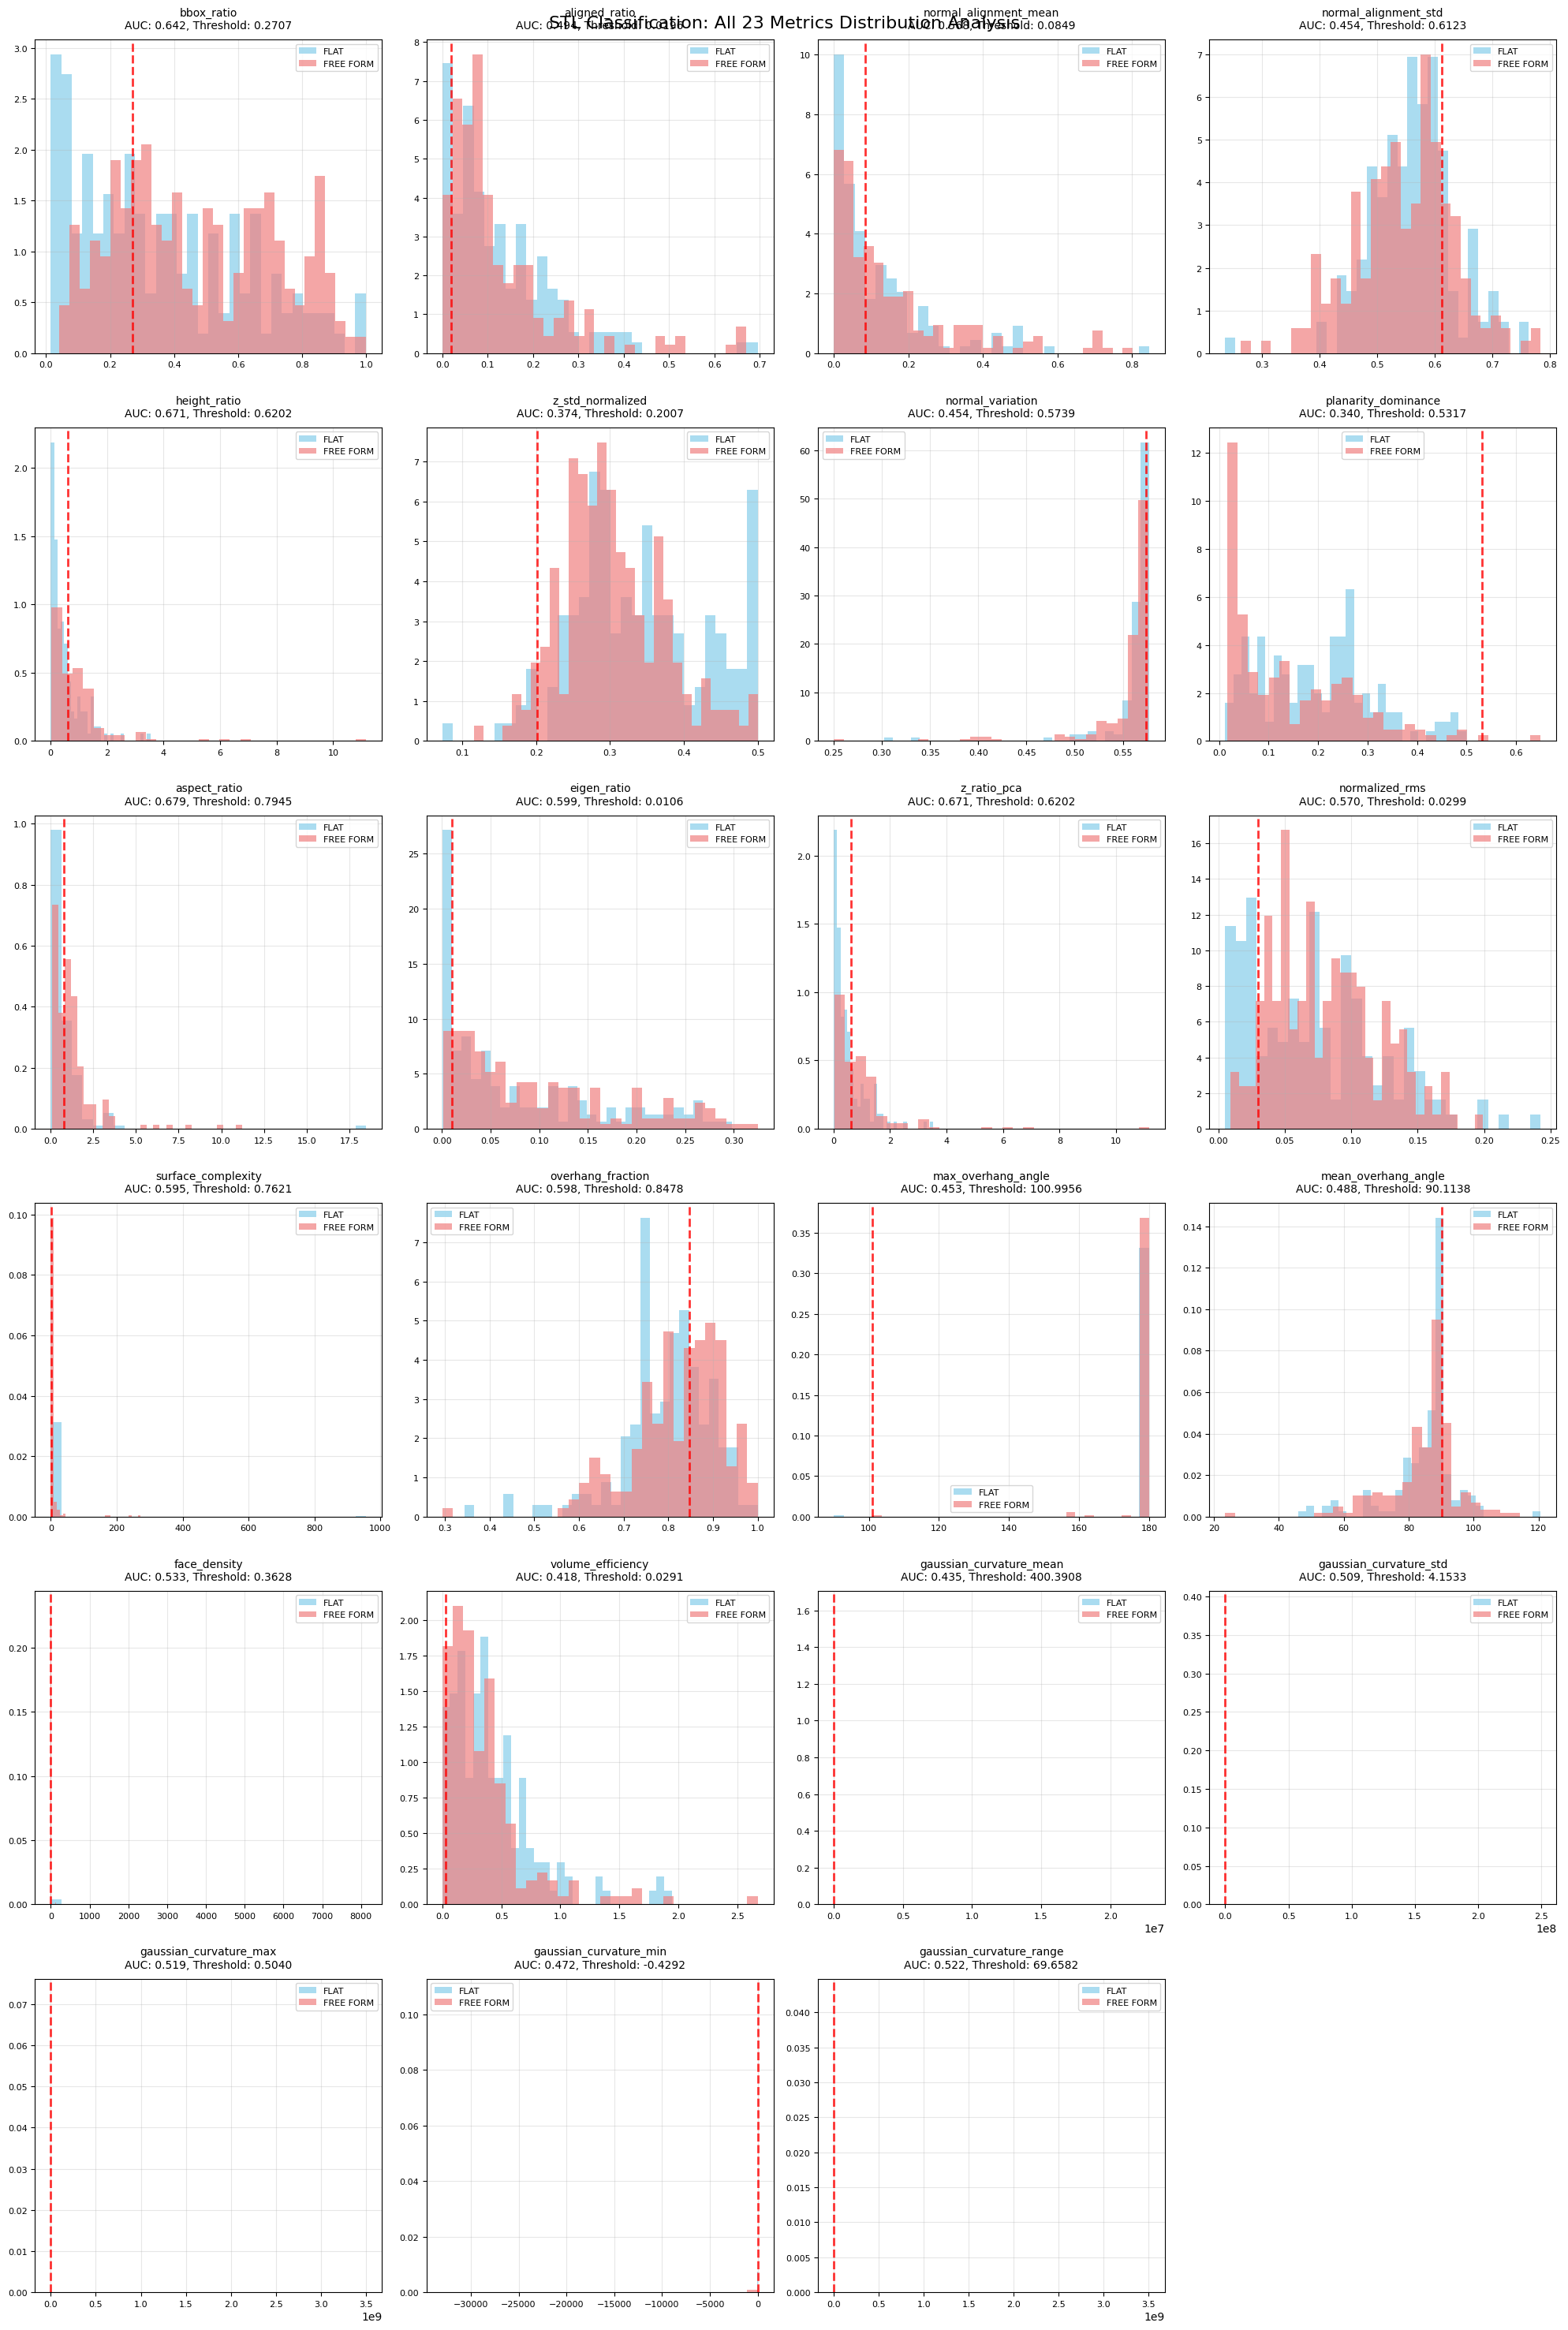


OPTIMAL THRESHOLD ANALYSIS
TOP 10 MOST DISCRIMINATIVE METRICS (by AUC score):
--------------------------------------------------------------------------------
Rank Metric                    AUC    Threshold    Separation
--------------------------------------------------------------------------------
1    aspect_ratio              0.679  0.7945       0.149     
2    z_ratio_pca               0.671  0.6202       0.233     
3    height_ratio              0.671  0.6202       0.233     
4    bbox_ratio                0.642  0.2707       0.235     
5    eigen_ratio               0.599  0.0106       0.117     
6    overhang_fraction         0.598  0.8478       0.147     
7    surface_complexity        0.595  0.7621       0.000     
8    normalized_rms            0.570  0.0299       0.092     
9    normal_alignment_mean     0.568  0.0849       0.122     
10   face_density              0.533  0.3628       0.075     

DETAILED THRESHOLD TABLE:
--------------------------------------------------

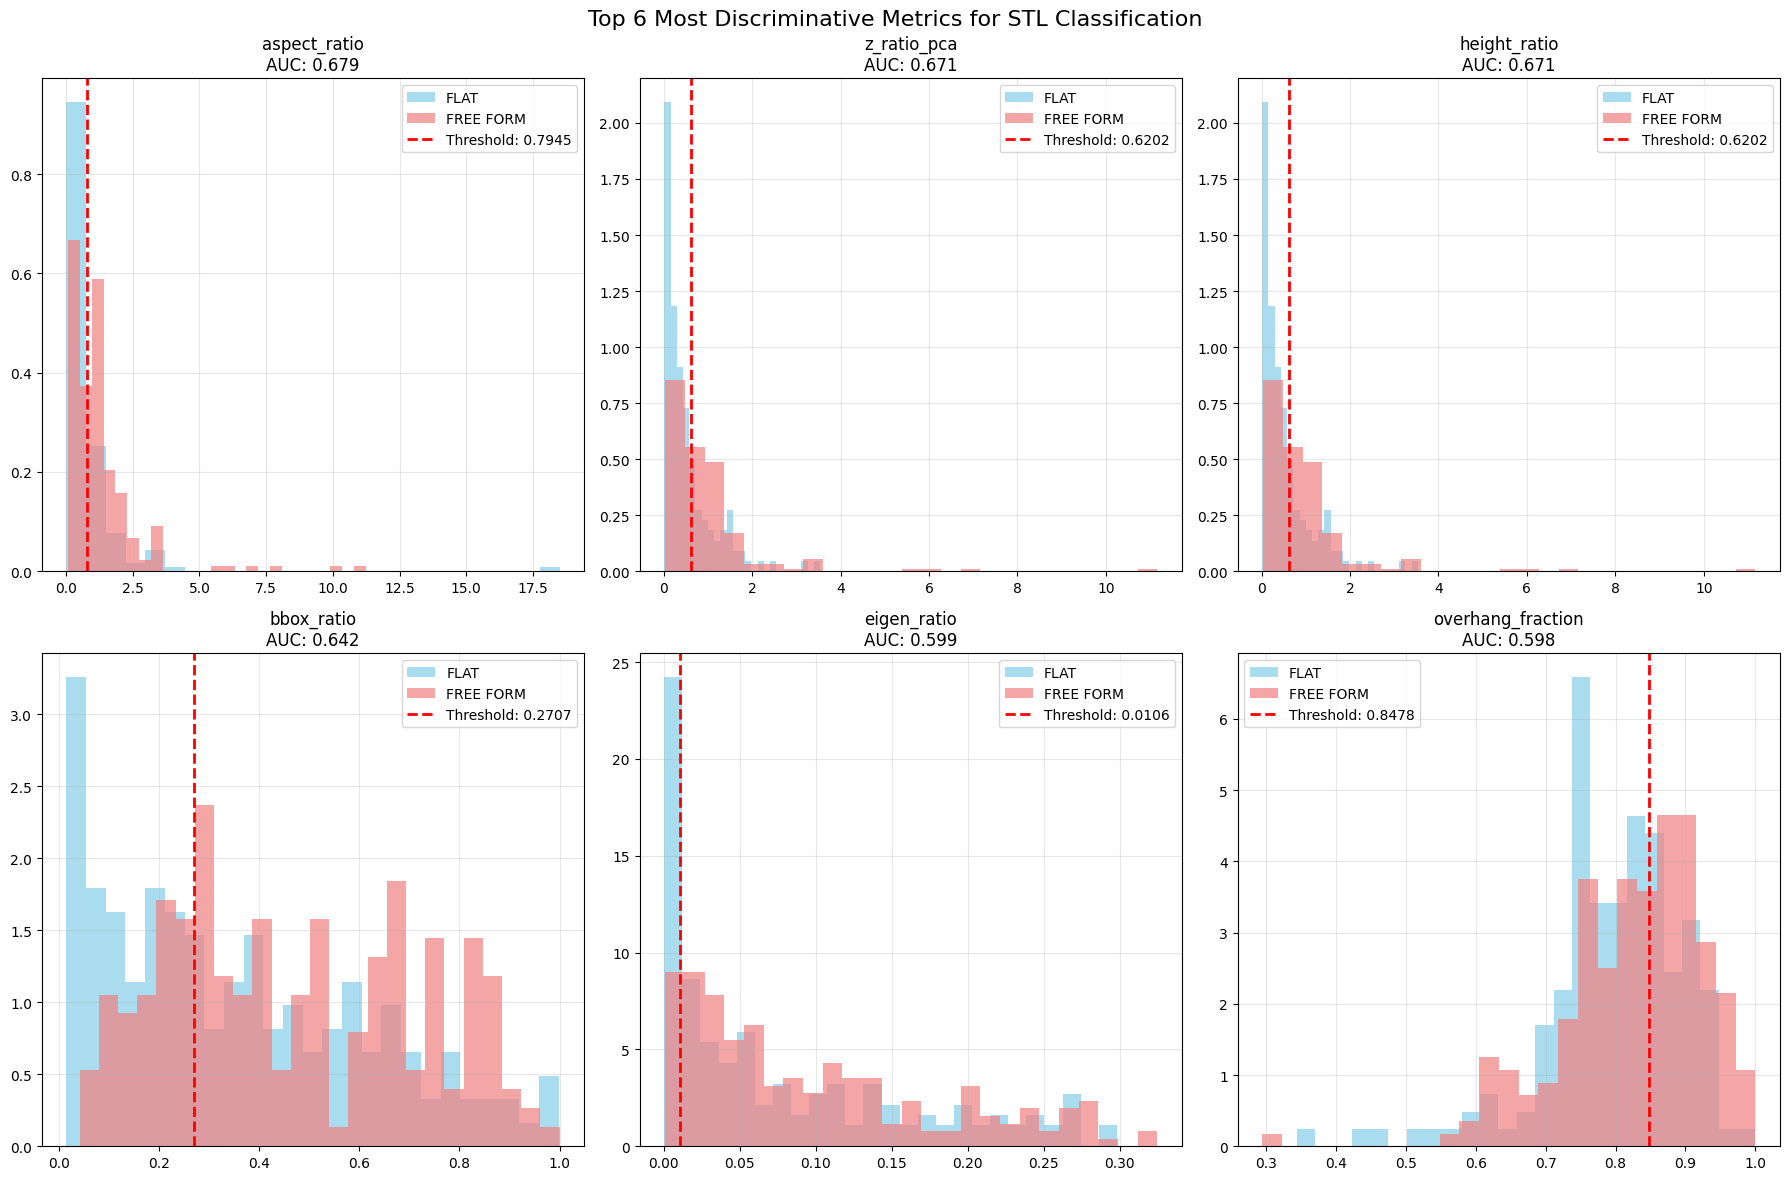


VISUALIZATION COMPLETE!
Use the threshold values above to classify new STL files
Red dashed lines show optimal separation thresholds
Higher AUC scores indicate better discriminative power


In [12]:
# --- Comprehensive Metric Visualization & Threshold Analysis ---
#%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

print("METRIC ANALYSIS & VISUALIZATION")

# Load the merged data
merged = pd.read_csv('all_metrics_with_labels_clean.csv')
merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]

print(f"Dataset: {len(merged)} files ({len(merged[merged['label']=='FLAT'])} FLAT, {len(merged[merged['label']=='FREE FORM'])} FREE FORM)")

# Get all metric columns (exclude filename and label)
metric_columns = [col for col in merged.columns if col not in ['filename', 'label']]
print(f"Analyzing {len(metric_columns)} metrics")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots for all metrics
n_metrics = len(metric_columns)
n_cols = 4  # 4 columns of plots
n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('STL Classification: All 23 Metrics Distribution Analysis', fontsize=16, y=0.98)

# Flatten axes array for easy indexing
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Store threshold analysis results
threshold_results = []

# Create histogram for each metric
for i, metric in enumerate(metric_columns):
    ax = axes_flat[i]

    # Get data for each class
    flat_data = merged[merged['label'] == 'FLAT'][metric].values
    freeform_data = merged[merged['label'] == 'FREE FORM'][metric].values

    # Remove any NaN or infinite values
    flat_data = flat_data[np.isfinite(flat_data)]
    freeform_data = freeform_data[np.isfinite(freeform_data)]

    if len(flat_data) == 0 or len(freeform_data) == 0:
        ax.text(0.5, 0.5, f'{metric}\n(No valid data)',
               ha='center', va='center', transform=ax.transAxes)
        continue

    # Create histograms
    bins = 30
    alpha = 0.7

    ax.hist(flat_data, bins=bins, alpha=alpha, label='FLAT', color='skyblue', density=True)
    ax.hist(freeform_data, bins=bins, alpha=alpha, label='FREE FORM', color='lightcoral', density=True)

    # Calculate optimal threshold using ROC curve
    y_true = np.concatenate([np.zeros(len(flat_data)), np.ones(len(freeform_data))])
    y_scores = np.concatenate([flat_data, freeform_data])

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Add vertical line for optimal threshold
    ax.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.8, linewidth=2)

    # Store results
    threshold_results.append({
        'metric': metric,
        'threshold': optimal_threshold,
        'auc': roc_auc,
        'sensitivity': tpr[optimal_idx],
        'specificity': 1 - fpr[optimal_idx],
        'flat_mean': np.mean(flat_data),
        'freeform_mean': np.mean(freeform_data),
        'separation': abs(np.mean(freeform_data) - np.mean(flat_data)) / (np.std(flat_data) + np.std(freeform_data))
    })

    # Set title with AUC score
    ax.set_title(f'{metric}\nAUC: {roc_auc:.3f}, Threshold: {optimal_threshold:.4f}',
                 fontsize=10, pad=10)

    # Formatting
    ax.legend(fontsize=8)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_metrics, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# CREATE THRESHOLD ANALYSIS SUMMARY
print("\nOPTIMAL THRESHOLD ANALYSIS")
print("="*60)

threshold_df = pd.DataFrame(threshold_results)

# Sort by AUC score (best discriminative power)
threshold_df_sorted = threshold_df.sort_values('auc', ascending=False, na_position='last')

print("TOP 10 MOST DISCRIMINATIVE METRICS (by AUC score):")
print("-" * 80)
print(f"{'Rank':<4} {'Metric':<25} {'AUC':<6} {'Threshold':<12} {'Separation':<10}")
print("-" * 80)

for i, row in threshold_df_sorted.head(10).iterrows():
    if pd.notna(row['auc']):
        print(f"{threshold_df_sorted.index.get_loc(i)+1:<4} {row['metric']:<25} {row['auc']:.3f}  {row['threshold']:<12.4f} {row['separation']:<10.3f}")

print("\nDETAILED THRESHOLD TABLE:")
print("-" * 100)
print(f"{'Metric':<25} {'Threshold':<12} {'AUC':<6} {'Sens':<6} {'Spec':<6} {'FLAT Mean':<10} {'FREE Mean':<10}")
print("-" * 100)

for _, row in threshold_df_sorted.head(15).iterrows():
    if pd.notna(row['auc']):
        print(f"{row['metric']:<25} {row['threshold']:<12.4f} {row['auc']:<6.3f} "
              f"{row['sensitivity']:<6.3f} {row['specificity']:<6.3f} "
              f"{row['flat_mean']:<10.4f} {row['freeform_mean']:<10.4f}")

# Create a summary plot of top metrics
print("\nCreating summary plot of top 6 metrics...")

top_6_metrics = threshold_df_sorted.head(6)['metric'].values

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Top 6 Most Discriminative Metrics for STL Classification', fontsize=16)
axes2_flat = axes2.flatten()

for i, metric in enumerate(top_6_metrics):
    ax = axes2_flat[i]

    flat_data = merged[merged['label'] == 'FLAT'][metric].values
    freeform_data = merged[merged['label'] == 'FREE FORM'][metric].values

    # Remove NaN values
    flat_data = flat_data[np.isfinite(flat_data)]
    freeform_data = freeform_data[np.isfinite(freeform_data)]

    # Create histograms
    ax.hist(flat_data, bins=25, alpha=0.7, label='FLAT', color='skyblue', density=True)
    ax.hist(freeform_data, bins=25, alpha=0.7, label='FREE FORM', color='lightcoral', density=True)

    # Add optimal threshold line
    threshold_row = threshold_df[threshold_df['metric'] == metric].iloc[0]
    if pd.notna(threshold_row['threshold']):
        ax.axvline(threshold_row['threshold'], color='red', linestyle='--', linewidth=2,
                  label=f"Threshold: {threshold_row['threshold']:.4f}")

    ax.set_title(f"{metric}\nAUC: {threshold_row['auc']:.3f}", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVISUALIZATION COMPLETE!")
print("Use the threshold values above to classify new STL files")
print("Red dashed lines show optimal separation thresholds")
print("Higher AUC scores indicate better discriminative power")


the histograms didnt show the gaussian curvature variations properly so trying to see them seperately, but seems like the values calculated are too big and many outliers are there. have to find another better way to find a curvature metric.

FOCUSED GAUSSIAN CURVATURE ANALYSIS
Analyzing 5 Gaussian curvature metrics
Dataset: 354 files (156 FLAT, 198 FREE FORM)

gaussian_curvature_mean:
   FLAT: min=-0.895169, max=15.078794, mean=0.375283
   FREE FORM: min=-90.308523, max=22818056.385633, mean=115244.109282
   99th percentile - FLAT: 10.069174, FREE FORM: 16.626159

gaussian_curvature_std:
   FLAT: min=0.000000, max=68.411948, mean=1.991142
   FREE FORM: min=0.000136, max=249546242.326495, mean=1260371.196736
   99th percentile - FLAT: 45.528531, FREE FORM: 1507.930141

gaussian_curvature_max:
   FLAT: min=0.000002, max=371.108742, mean=10.725135
   FREE FORM: min=0.000506, max=3506195469.221627, mean=17708376.469845
   99th percentile - FLAT: 274.327024, FREE FORM: 2375.915087

gaussian_curvature_min:
   FLAT: min=-232.629625, max=0.020033, mean=-8.687608
   FREE FORM: min=-32981.227086, max=-0.000497, mean=-309.406524
   99th percentile - FLAT: -0.000514, FREE FORM: -0.000696

gaussian_curvature_range:
   FLAT: min=0.00000

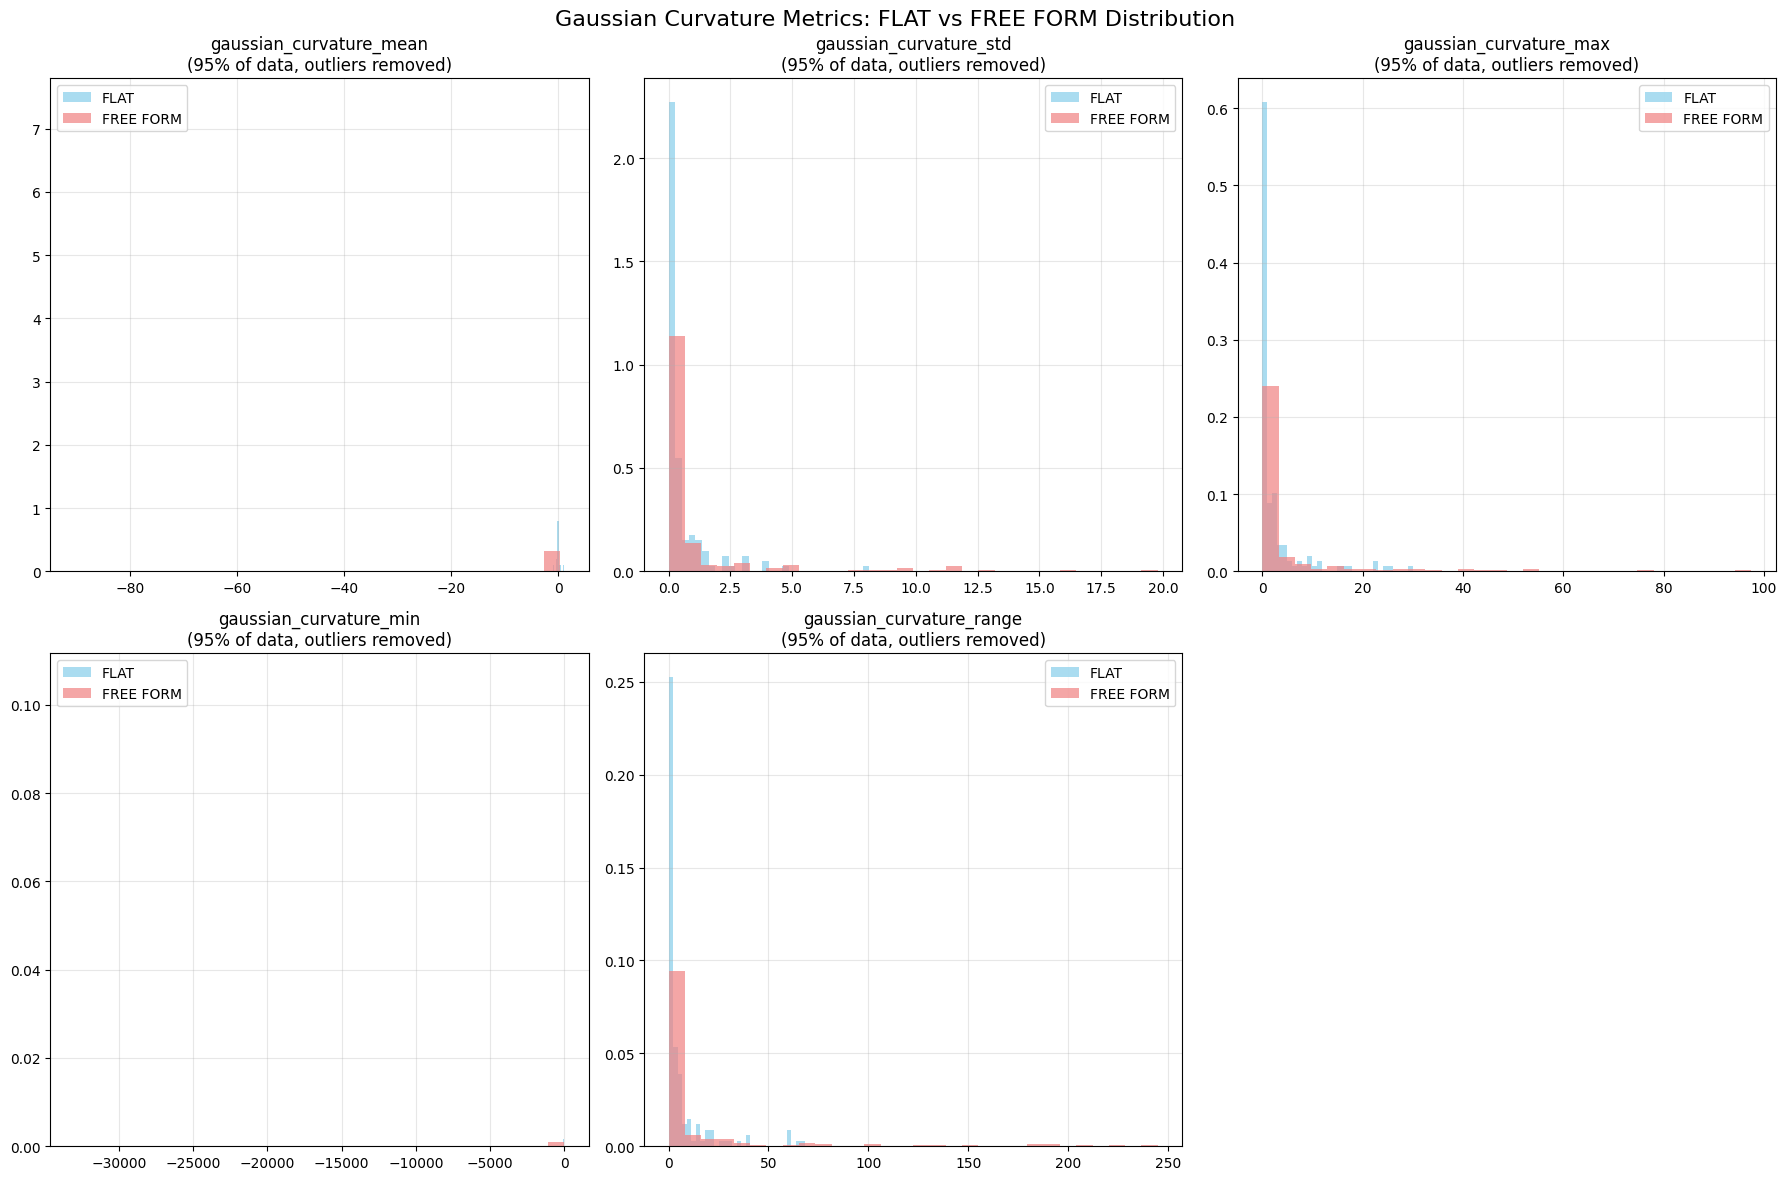


ANALYSIS SUMMARY:
Gaussian curvature metrics are included in the analysis.
They appear in the full 23-metric visualization but are not among the top discriminative metrics by AUC.
Possible issues: extreme outliers, scale problems, or inherently low discriminative power.


In [13]:
# --- Focused Gaussian Curvature Analysis ---
print("FOCUSED GAUSSIAN CURVATURE ANALYSIS")

# Load the merged data
merged = pd.read_csv('all_metrics_with_labels_clean.csv')
merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]

# Focus on Gaussian curvature metrics only
gaussian_metrics = [
    'gaussian_curvature_mean',
    'gaussian_curvature_std',
    'gaussian_curvature_max',
    'gaussian_curvature_min',
    'gaussian_curvature_range'
 ]

print(f"Analyzing {len(gaussian_metrics)} Gaussian curvature metrics")
print(f"Dataset: {len(merged)} files ({len(merged[merged['label']=='FLAT'])} FLAT, {len(merged[merged['label']=='FREE FORM'])} FREE FORM)")

# Create figure for Gaussian curvature metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Gaussian Curvature Metrics: FLAT vs FREE FORM Distribution', fontsize=16)
axes_flat = axes.flatten()

for i, metric in enumerate(gaussian_metrics):
    ax = axes_flat[i]

    if metric not in merged.columns:
        ax.text(0.5, 0.5, f'{metric}\n(Not present in data)', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(metric)
        continue

    # Get data for each class
    flat_data = merged[merged['label'] == 'FLAT'][metric].values
    freeform_data = merged[merged['label'] == 'FREE FORM'][metric].values

    # Remove any NaN or infinite values
    flat_data = flat_data[np.isfinite(flat_data)]
    freeform_data = freeform_data[np.isfinite(freeform_data)]

    if len(flat_data) == 0 or len(freeform_data) == 0:
        ax.text(0.5, 0.5, f'{metric}\n(No valid data)', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(metric)
        continue

    print(f"\n{metric}:")
    print(f"   FLAT: min={np.min(flat_data):.6f}, max={np.max(flat_data):.6f}, mean={np.mean(flat_data):.6f}")
    print(f"   FREE FORM: min={np.min(freeform_data):.6f}, max={np.max(freeform_data):.6f}, mean={np.mean(freeform_data):.6f}")

    # Check for extreme outliers
    flat_q99 = np.percentile(flat_data, 99)
    freeform_q99 = np.percentile(freeform_data, 99)
    print(f"   99th percentile - FLAT: {flat_q99:.6f}, FREE FORM: {freeform_q99:.6f}")

    # Create histograms with outlier removal (central 95%)
    flat_filtered = flat_data[flat_data <= np.percentile(flat_data, 95)]
    freeform_filtered = freeform_data[freeform_data <= np.percentile(freeform_data, 95)]

    range_ratio = (np.max(freeform_filtered) - np.min(flat_filtered)) / (np.std(flat_filtered) + np.std(freeform_filtered) + 1e-9)
    use_log = range_ratio > 1000

    if use_log and np.all(flat_filtered > 0) and np.all(freeform_filtered > 0):
        ax.hist(np.log10(flat_filtered + 1e-9), bins=30, alpha=0.7, label='FLAT', color='skyblue', density=True)
        ax.hist(np.log10(freeform_filtered + 1e-9), bins=30, alpha=0.7, label='FREE FORM', color='lightcoral', density=True)
        ax.set_xlabel('log10(value)')
        ax.set_title(f'{metric}\n(Log Scale, 95% of data)')
    else:
        ax.hist(flat_filtered, bins=30, alpha=0.7, label='FLAT', color='skyblue', density=True)
        ax.hist(freeform_filtered, bins=30, alpha=0.7, label='FREE FORM', color='lightcoral', density=True)
        ax.set_title(f'{metric}\n(95% of data, outliers removed)')

    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot (unused)
axes_flat[5].set_visible(False)

plt.tight_layout()
plt.show()

print("\nANALYSIS SUMMARY:")
print("Gaussian curvature metrics are included in the analysis.")
print("They appear in the full 23-metric visualization but are not among the top discriminative metrics by AUC.")
print("Possible issues: extreme outliers, scale problems, or inherently low discriminative power.")


find the top 10 metrics for flat n free form models seperately.

VOTING-BASED CLASSIFIER ANALYSIS
Finding metrics that specialize in detecting FLAT vs FREE FORM separately
Dataset: 354 files (156 FLAT, 198 FREE FORM)
Analyzing 23 metrics

SPECIALIST METRICS ANALYSIS

TOP 10 FLAT DETECTION SPECIALISTS:
------------------------------------------------------------------------------------------
Rank Metric                    FLAT Detect  Direction            Threshold 
------------------------------------------------------------------------------------------
1    gaussian_curvature_mean   1.000        Lower->FLAT          400.3908  
2    max_overhang_angle        1.000        Higher->FLAT         100.9956  
3    z_std_normalized          0.960        Higher->FLAT         0.2007    
4    gaussian_curvature_range  0.949        Lower->FLAT          69.6582   
5    gaussian_curvature_std    0.936        Lower->FLAT          4.1533    
6    volume_efficiency         0.934        Higher->FLAT         0.0291    
7    surface_complexity        0.814        Lowe

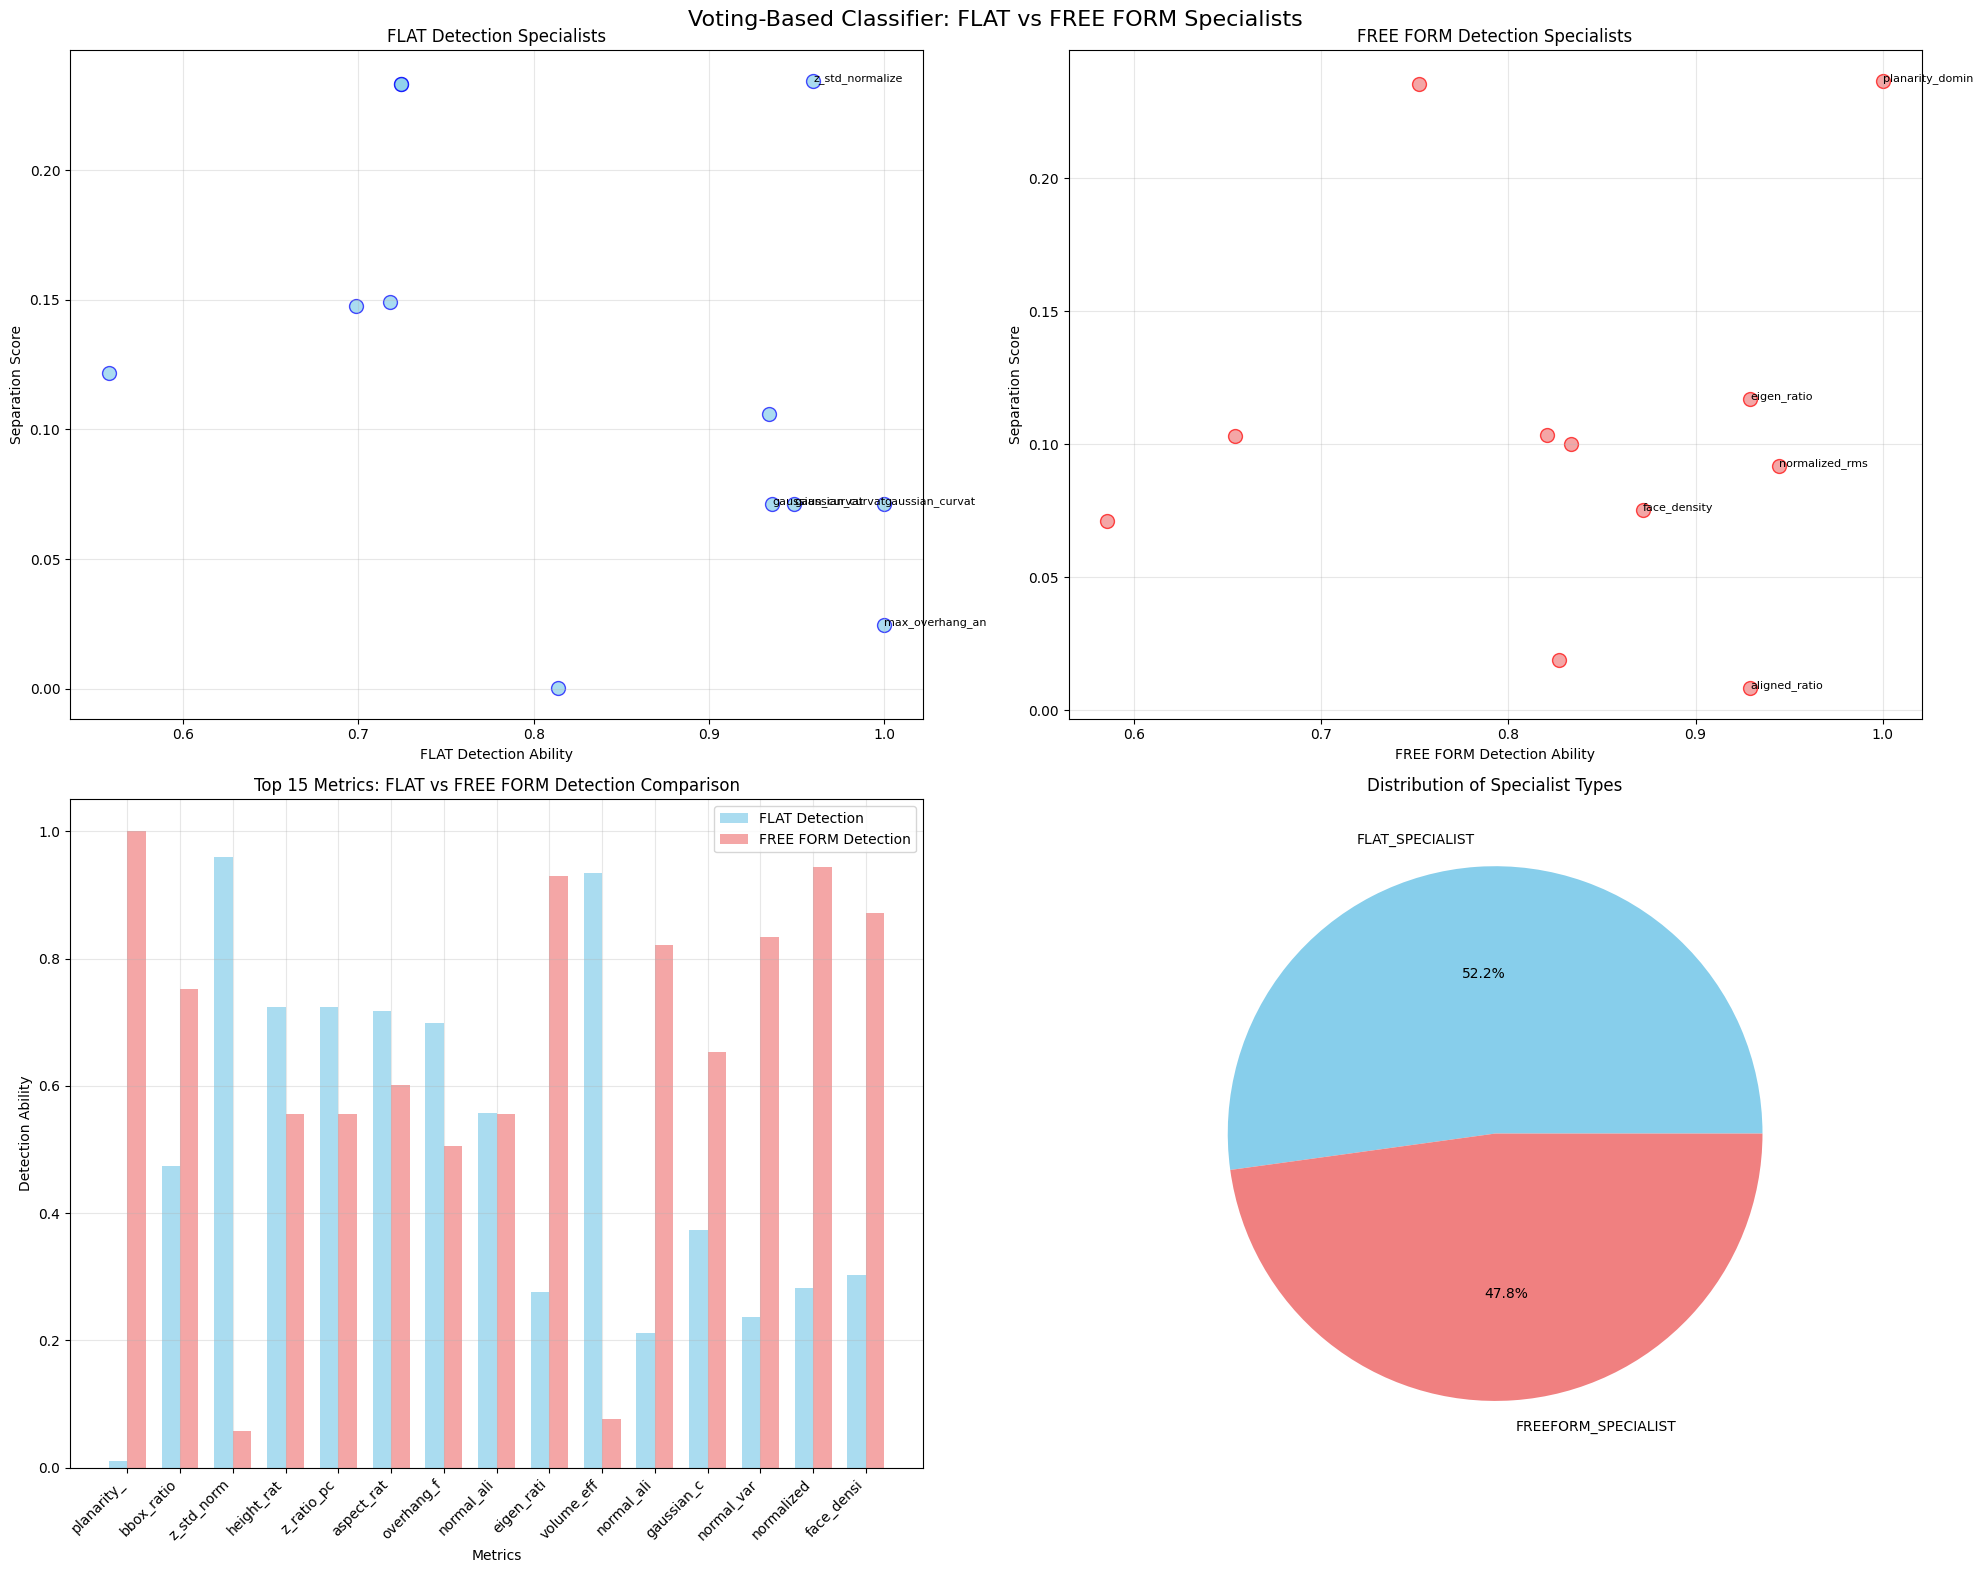


VOTING CLASSIFIER DESIGN
Selected FLAT specialists: ['gaussian_curvature_mean', 'max_overhang_angle', 'z_std_normalized', 'gaussian_curvature_range', 'gaussian_curvature_std']
Selected FREE FORM specialists: ['planarity_dominance', 'normalized_rms', 'aligned_ratio', 'eigen_ratio', 'face_density']

Voting configuration saved!
Analysis complete! Ready to implement voting classifier.


In [14]:
# --- Voting-Based Classifier: FLAT vs FREE FORM Specialists ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

print("VOTING-BASED CLASSIFIER ANALYSIS")
print("Finding metrics that specialize in detecting FLAT vs FREE FORM separately")

# Load the merged data
merged = pd.read_csv('all_metrics_with_labels_clean.csv')
merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]

print(f"Dataset: {len(merged)} files ({len(merged[merged['label']=='FLAT'])} FLAT, {len(merged[merged['label']=='FREE FORM'])} FREE FORM)")

# Get all metric columns
metric_columns = [col for col in merged.columns if col not in ['filename', 'label']]
print(f"Analyzing {len(metric_columns)} metrics")

# Analyze each metric for FLAT and FREE FORM detection capabilities
voting_results = []

for metric in metric_columns:
    # Get data for each class
    flat_data = merged[merged['label'] == 'FLAT'][metric].values
    freeform_data = merged[merged['label'] == 'FREE FORM'][metric].values
    
    # Remove any NaN or infinite values
    flat_data = flat_data[np.isfinite(flat_data)]
    freeform_data = freeform_data[np.isfinite(freeform_data)]
    
    if len(flat_data) == 0 or len(freeform_data) == 0:
        continue
        
    # Calculate statistics
    flat_mean = np.mean(flat_data)
    flat_std = np.std(flat_data)
    freeform_mean = np.mean(freeform_data)
    freeform_std = np.std(freeform_data)
    
    # ROC analysis for both directions
    y_true = np.concatenate([np.zeros(len(flat_data)), np.ones(len(freeform_data))])
    y_scores = np.concatenate([flat_data, freeform_data])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    sensitivity = tpr[optimal_idx]  # True Positive Rate (FREE FORM detection)
    specificity = 1 - fpr[optimal_idx]  # True Negative Rate (FLAT detection)
    
    # Calculate directional preferences
    # If FLAT values are generally lower, metric is good for FLAT detection when threshold is low
    # If FREE FORM values are generally higher, metric is good for FREE FORM detection when threshold is high
    
    direction_bias = "HIGHER_FOR_FREEFORM" if freeform_mean > flat_mean else "HIGHER_FOR_FLAT"
    
    # Calculate class-specific detection capabilities
    if direction_bias == "HIGHER_FOR_FREEFORM":
        # Higher values indicate FREE FORM
        flat_detection_ability = specificity  # How well it identifies FLAT (low values)
        freeform_detection_ability = sensitivity  # How well it identifies FREE FORM (high values)
        flat_threshold = optimal_threshold  # Values below this are likely FLAT
        freeform_threshold = optimal_threshold  # Values above this are likely FREE FORM
    else:
        # Higher values indicate FLAT
        flat_detection_ability = sensitivity  # How well it identifies FLAT (high values)  
        freeform_detection_ability = specificity  # How well it identifies FREE FORM (low values)
        flat_threshold = optimal_threshold  # Values above this are likely FLAT
        freeform_threshold = optimal_threshold  # Values below this are likely FREE FORM
    
    # Separation quality
    separation_score = abs(freeform_mean - flat_mean) / (flat_std + freeform_std + 1e-9)
    
    # Class dominance (which class this metric is better at detecting)
    if flat_detection_ability > freeform_detection_ability:
        specialist_type = "FLAT_SPECIALIST"
        specialist_score = flat_detection_ability
    else:
        specialist_type = "FREEFORM_SPECIALIST" 
        specialist_score = freeform_detection_ability
    
    voting_results.append({
        'metric': metric,
        'auc': roc_auc,
        'flat_detection_ability': flat_detection_ability,
        'freeform_detection_ability': freeform_detection_ability,
        'flat_mean': flat_mean,
        'freeform_mean': freeform_mean,
        'flat_std': flat_std,
        'freeform_std': freeform_std,
        'separation_score': separation_score,
        'direction_bias': direction_bias,
        'specialist_type': specialist_type,
        'specialist_score': specialist_score,
        'optimal_threshold': optimal_threshold,
        'flat_threshold': flat_threshold,
        'freeform_threshold': freeform_threshold
    })

# Convert to DataFrame
voting_df = pd.DataFrame(voting_results)

# Separate specialists
flat_specialists = voting_df[voting_df['specialist_type'] == 'FLAT_SPECIALIST'].sort_values('specialist_score', ascending=False)
freeform_specialists = voting_df[voting_df['specialist_type'] == 'FREEFORM_SPECIALIST'].sort_values('specialist_score', ascending=False)

print(f"\nSPECIALIST METRICS ANALYSIS")
print("="*60)

print(f"\nTOP 10 FLAT DETECTION SPECIALISTS:")
print("-" * 90)
print(f"{'Rank':<4} {'Metric':<25} {'FLAT Detect':<12} {'Direction':<20} {'Threshold':<10}")
print("-" * 90)

for i, (_, row) in enumerate(flat_specialists.head(10).iterrows(), 1):
    direction = "Higher->FLAT" if row['direction_bias'] == "HIGHER_FOR_FLAT" else "Lower->FLAT"
    print(f"{i:<4} {row['metric']:<25} {row['flat_detection_ability']:<12.3f} {direction:<20} {row['flat_threshold']:<10.4f}")

print(f"\nTOP 10 FREE FORM DETECTION SPECIALISTS:")
print("-" * 90)
print(f"{'Rank':<4} {'Metric':<25} {'FF Detect':<12} {'Direction':<20} {'Threshold':<10}")
print("-" * 90)

for i, (_, row) in enumerate(freeform_specialists.head(10).iterrows(), 1):
    direction = "Higher->FF" if row['direction_bias'] == "HIGHER_FOR_FREEFORM" else "Lower->FF"
    print(f"{i:<4} {row['metric']:<25} {row['freeform_detection_ability']:<12.3f} {direction:<20} {row['freeform_threshold']:<10.4f}")

# Create visualization
print(f"\nCreating specialist visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Voting-Based Classifier: FLAT vs FREE FORM Specialists', fontsize=16)

# 1. FLAT Specialists scatter plot
ax1.scatter(flat_specialists['flat_detection_ability'], flat_specialists['separation_score'], 
           s=100, alpha=0.7, c='skyblue', edgecolors='blue')
for i, row in flat_specialists.head(5).iterrows():
    ax1.annotate(row['metric'][:15], (row['flat_detection_ability'], row['separation_score']), 
                fontsize=8, ha='left')
ax1.set_xlabel('FLAT Detection Ability')
ax1.set_ylabel('Separation Score')
ax1.set_title('FLAT Detection Specialists')
ax1.grid(True, alpha=0.3)

# 2. FREE FORM Specialists scatter plot  
ax2.scatter(freeform_specialists['freeform_detection_ability'], freeform_specialists['separation_score'],
           s=100, alpha=0.7, c='lightcoral', edgecolors='red')
for i, row in freeform_specialists.head(5).iterrows():
    ax2.annotate(row['metric'][:15], (row['freeform_detection_ability'], row['separation_score']),
                fontsize=8, ha='left')
ax2.set_xlabel('FREE FORM Detection Ability')
ax2.set_ylabel('Separation Score')
ax2.set_title('FREE FORM Detection Specialists')
ax2.grid(True, alpha=0.3)

# 3. Combined comparison
all_metrics = voting_df['metric'].values
flat_scores = voting_df['flat_detection_ability'].values
freeform_scores = voting_df['freeform_detection_ability'].values

x = np.arange(len(all_metrics))
width = 0.35

# Only show top metrics to avoid overcrowding
top_n = 15
top_indices = voting_df.nlargest(top_n, 'separation_score').index

ax3.bar(x[:top_n] - width/2, flat_scores[top_indices], width, label='FLAT Detection', alpha=0.7, color='skyblue')
ax3.bar(x[:top_n] + width/2, freeform_scores[top_indices], width, label='FREE FORM Detection', alpha=0.7, color='lightcoral')
ax3.set_xlabel('Metrics')
ax3.set_ylabel('Detection Ability')
ax3.set_title('Top 15 Metrics: FLAT vs FREE FORM Detection Comparison')
ax3.set_xticks(x[:top_n])
ax3.set_xticklabels([all_metrics[i][:10] for i in top_indices], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Specialist distribution
specialist_counts = voting_df['specialist_type'].value_counts()
ax4.pie(specialist_counts.values, labels=specialist_counts.index, autopct='%1.1f%%', 
       colors=['skyblue', 'lightcoral'])
ax4.set_title('Distribution of Specialist Types')

plt.tight_layout()
plt.show()

# Voting classifier design
print(f"\nVOTING CLASSIFIER DESIGN")
print("="*60)

# Select top specialists
top_flat_specialists = flat_specialists.head(5)['metric'].tolist()
top_freeform_specialists = freeform_specialists.head(5)['metric'].tolist()

print(f"Selected FLAT specialists: {top_flat_specialists}")
print(f"Selected FREE FORM specialists: {top_freeform_specialists}")

# Save voting configuration
voting_config = {
    'flat_specialists': top_flat_specialists,
    'freeform_specialists': top_freeform_specialists,
    'flat_thresholds': {metric: voting_df[voting_df['metric'] == metric]['flat_threshold'].iloc[0] 
                       for metric in top_flat_specialists},
    'freeform_thresholds': {metric: voting_df[voting_df['metric'] == metric]['freeform_threshold'].iloc[0] 
                           for metric in top_freeform_specialists},
    'flat_directions': {metric: voting_df[voting_df['metric'] == metric]['direction_bias'].iloc[0] 
                       for metric in top_flat_specialists},
    'freeform_directions': {metric: voting_df[voting_df['metric'] == metric]['direction_bias'].iloc[0] 
                           for metric in top_freeform_specialists}
}

print(f"\nVoting configuration saved!")
print(f"Analysis complete! Ready to implement voting classifier.")

# Store results for next step
globals()['voting_config'] = voting_config
globals()['voting_df'] = voting_df


Prediction using the top 5 flat and top5 free form models (total 10 metrics)

VOTING CLASSIFIER IMPLEMENTATION
Testing voting classifier on the dataset...

VOTING CLASSIFIER RESULTS
Accuracy: 0.5876 (58.8%)

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.53      0.52      0.53       156
   FREE FORM       0.63      0.64      0.64       198

    accuracy                           0.59       354
   macro avg       0.58      0.58      0.58       354
weighted avg       0.59      0.59      0.59       354


Confusion Matrix:
             Predicted
           FLAT  FREE FORM
Actual FLAT     81        75
   FREE FORM    71       127

Average Confidence: -25299.9849 (-2529998.5%)

Voting Statistics:
   Average FLAT votes per prediction: 4.75/5
   Average FREE FORM votes per prediction: 4.34/5


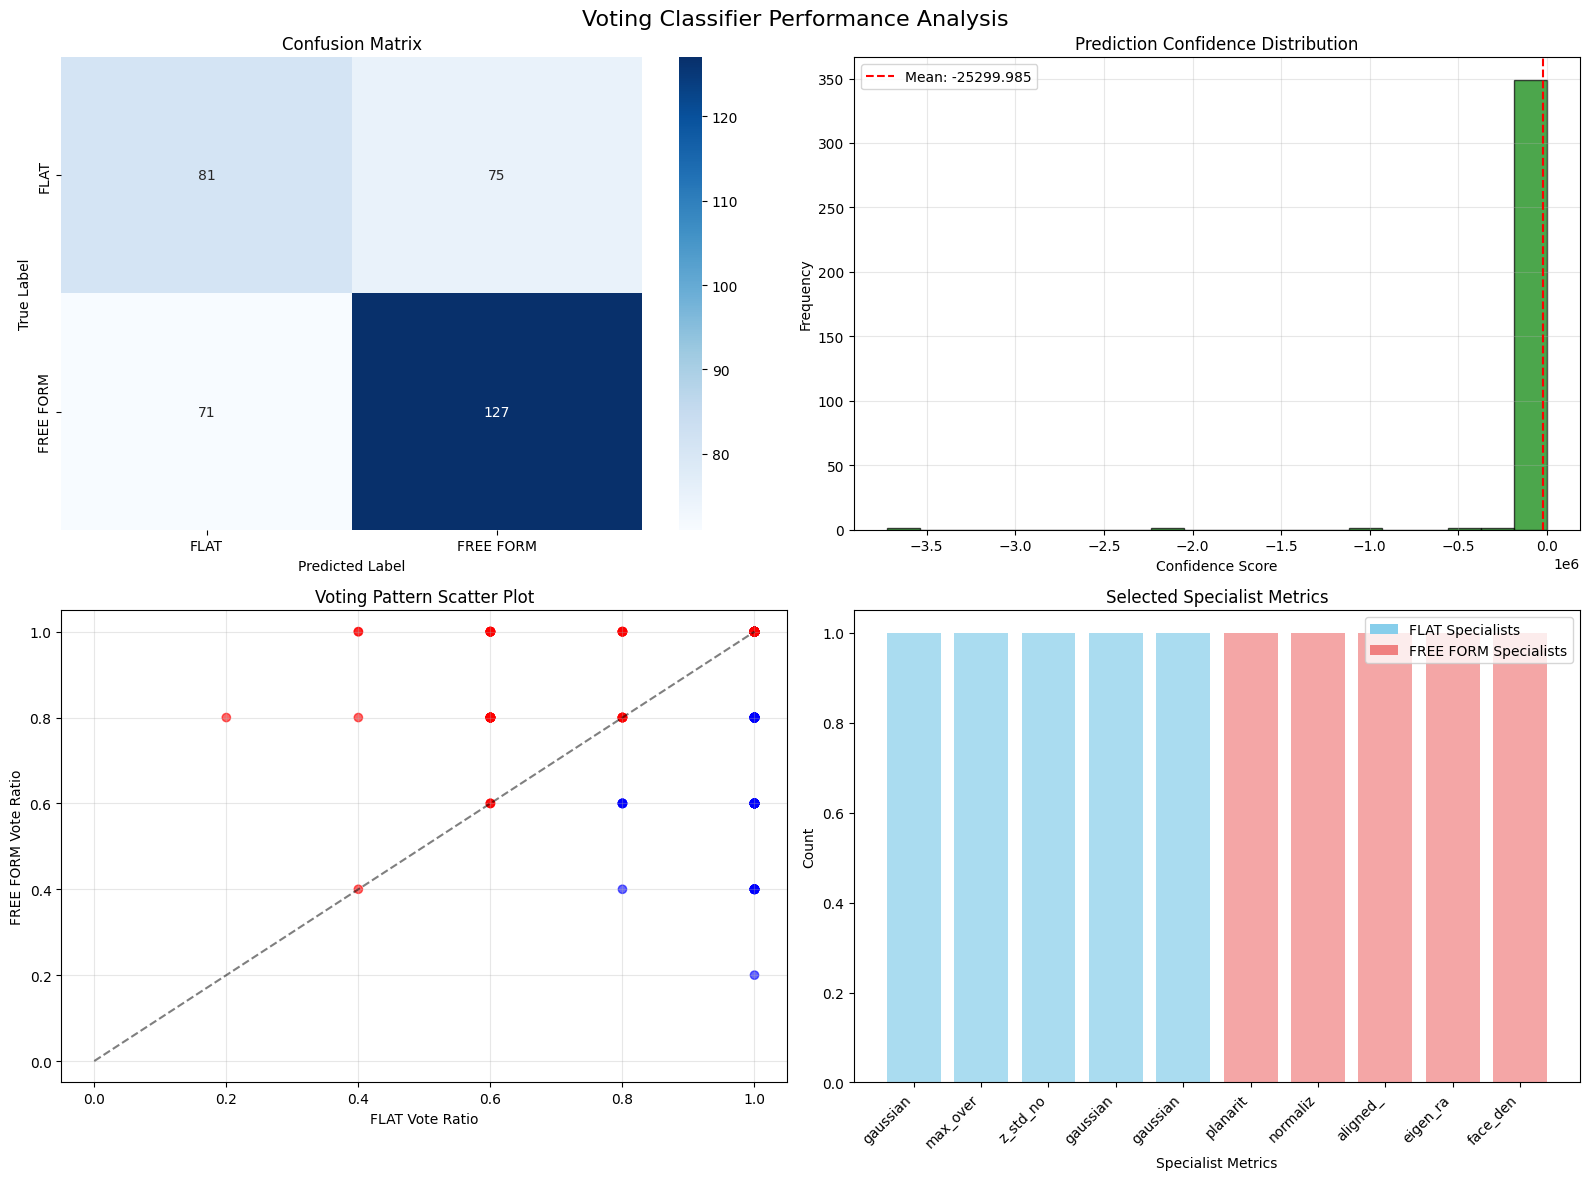


VOTING CLASSIFIER EVALUATION COMPLETE!
The voting classifier achieved 58.8% accuracy
This approach uses 5 FLAT specialists and 5 FREE FORM specialists


In [15]:
# --- Voting Classifier Implementation ---
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("VOTING CLASSIFIER IMPLEMENTATION")

def voting_classifier_predict(metrics_dict, voting_config):
    """
    Voting-based classifier using specialist metrics
    
    Args:
        metrics_dict: Dictionary of metric values for a single sample
        voting_config: Configuration with specialist metrics and thresholds
    
    Returns:
        Dictionary with prediction results
    """
    flat_votes = 0
    freeform_votes = 0
    flat_confidence_scores = []
    freeform_confidence_scores = []
    
    # FLAT specialist votes
    for metric in voting_config['flat_specialists']:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = voting_config['flat_thresholds'][metric]
            direction = voting_config['flat_directions'][metric]
            
            # Determine if this metric votes for FLAT
            if direction == "HIGHER_FOR_FLAT":
                # Higher values indicate FLAT
                if value >= threshold:
                    flat_votes += 1
                    flat_confidence_scores.append(min(value / threshold, 2.0))  # Cap confidence
                else:
                    flat_confidence_scores.append(max(value / threshold, 0.1))  # Min confidence
            else:
                # Lower values indicate FLAT  
                if value <= threshold:
                    flat_votes += 1
                    flat_confidence_scores.append(min(threshold / (value + 1e-9), 2.0))
                else:
                    flat_confidence_scores.append(max(threshold / (value + 1e-9), 0.1))
    
    # FREE FORM specialist votes
    for metric in voting_config['freeform_specialists']:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = voting_config['freeform_thresholds'][metric]
            direction = voting_config['freeform_directions'][metric]
            
            # Determine if this metric votes for FREE FORM
            if direction == "HIGHER_FOR_FREEFORM":
                # Higher values indicate FREE FORM
                if value >= threshold:
                    freeform_votes += 1
                    freeform_confidence_scores.append(min(value / threshold, 2.0))
                else:
                    freeform_confidence_scores.append(max(value / threshold, 0.1))
            else:
                # Lower values indicate FREE FORM
                if value <= threshold:
                    freeform_votes += 1
                    freeform_confidence_scores.append(min(threshold / (value + 1e-9), 2.0))
                else:
                    freeform_confidence_scores.append(max(threshold / (value + 1e-9), 0.1))
    
    # Calculate final prediction
    total_flat_specialists = len(voting_config['flat_specialists'])
    total_freeform_specialists = len(voting_config['freeform_specialists'])
    
    flat_vote_ratio = flat_votes / total_flat_specialists if total_flat_specialists > 0 else 0
    freeform_vote_ratio = freeform_votes / total_freeform_specialists if total_freeform_specialists > 0 else 0
    
    # Average confidence scores
    avg_flat_confidence = np.mean(flat_confidence_scores) if flat_confidence_scores else 0.5
    avg_freeform_confidence = np.mean(freeform_confidence_scores) if freeform_confidence_scores else 0.5
    
    # Final decision
    if flat_vote_ratio > freeform_vote_ratio:
        prediction = "FLAT"
        confidence = flat_vote_ratio * avg_flat_confidence
    elif freeform_vote_ratio > flat_vote_ratio:
        prediction = "FREE FORM"  
        confidence = freeform_vote_ratio * avg_freeform_confidence
    else:
        # Tie-breaking: use confidence scores
        if avg_flat_confidence > avg_freeform_confidence:
            prediction = "FLAT"
            confidence = avg_flat_confidence * 0.5  # Reduce confidence for ties
        else:
            prediction = "FREE FORM"
            confidence = avg_freeform_confidence * 0.5
    
    return {
        'prediction': prediction,
        'confidence': min(confidence, 1.0),  # Cap at 100%
        'flat_votes': flat_votes,
        'freeform_votes': freeform_votes,
        'flat_vote_ratio': flat_vote_ratio,
        'freeform_vote_ratio': freeform_vote_ratio,
        'flat_specialists_count': total_flat_specialists,
        'freeform_specialists_count': total_freeform_specialists
    }

# Test the voting classifier on the dataset
if 'voting_config' in globals():
    print("Testing voting classifier on the dataset...")
    
    # Load test data
    merged = pd.read_csv('all_metrics_with_labels_clean.csv')
    merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]
    
    predictions = []
    confidences = []
    voting_details = []
    
    for idx, row in merged.iterrows():
        # Create metrics dictionary for this sample
        metrics_dict = {col: row[col] for col in merged.columns if col not in ['filename', 'label']}
        
        # Make prediction
        result = voting_classifier_predict(metrics_dict, voting_config)
        
        predictions.append(result['prediction'])
        confidences.append(result['confidence'])
        voting_details.append(result)
    
    # Evaluate performance
    true_labels = merged['label'].values
    accuracy = accuracy_score(true_labels, predictions)
    
    print(f"\nVOTING CLASSIFIER RESULTS")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    
    # Detailed classification report
    print(f"\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=['FLAT', 'FREE FORM'])
    print(f"\nConfusion Matrix:")
    print(f"             Predicted")
    print(f"           FLAT  FREE FORM")
    print(f"Actual FLAT   {cm[0,0]:4d}      {cm[0,1]:4d}")
    print(f"   FREE FORM  {cm[1,0]:4d}      {cm[1,1]:4d}")
    
    # Confidence analysis
    avg_confidence = np.mean(confidences)
    print(f"\nAverage Confidence: {avg_confidence:.4f} ({avg_confidence*100:.1f}%)")
    
    # Voting statistics
    flat_votes_avg = np.mean([d['flat_votes'] for d in voting_details])
    freeform_votes_avg = np.mean([d['freeform_votes'] for d in voting_details])
    
    print(f"\nVoting Statistics:")
    print(f"   Average FLAT votes per prediction: {flat_votes_avg:.2f}/{voting_config['flat_specialists'].__len__()}")
    print(f"   Average FREE FORM votes per prediction: {freeform_votes_avg:.2f}/{voting_config['freeform_specialists'].__len__()}")
    
    # Visualize results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Voting Classifier Performance Analysis', fontsize=16)
    
    # 1. Confusion Matrix Heatmap
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'], ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. Confidence Distribution
    ax2.hist(confidences, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(avg_confidence, color='red', linestyle='--', label=f'Mean: {avg_confidence:.3f}')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Prediction Confidence Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Voting Pattern Analysis
    flat_vote_ratios = [d['flat_vote_ratio'] for d in voting_details]
    freeform_vote_ratios = [d['freeform_vote_ratio'] for d in voting_details]
    
    ax3.scatter(flat_vote_ratios, freeform_vote_ratios, alpha=0.6, 
               c=['blue' if p == 'FLAT' else 'red' for p in predictions])
    ax3.set_xlabel('FLAT Vote Ratio')
    ax3.set_ylabel('FREE FORM Vote Ratio')
    ax3.set_title('Voting Pattern Scatter Plot')
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
    ax3.grid(True, alpha=0.3)
    
    # 4. Specialist Contribution
    specialist_names = voting_config['flat_specialists'] + voting_config['freeform_specialists']
    specialist_types = ['FLAT'] * len(voting_config['flat_specialists']) + ['FREE FORM'] * len(voting_config['freeform_specialists'])
    colors = ['skyblue'] * len(voting_config['flat_specialists']) + ['lightcoral'] * len(voting_config['freeform_specialists'])
    
    ax4.bar(range(len(specialist_names)), [1] * len(specialist_names), color=colors, alpha=0.7)
    ax4.set_xlabel('Specialist Metrics')
    ax4.set_ylabel('Count')
    ax4.set_title('Selected Specialist Metrics')
    ax4.set_xticks(range(len(specialist_names)))
    ax4.set_xticklabels([name[:8] for name in specialist_names], rotation=45, ha='right')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='skyblue', label='FLAT Specialists'),
                      Patch(facecolor='lightcoral', label='FREE FORM Specialists')]
    ax4.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVOTING CLASSIFIER EVALUATION COMPLETE!")
    print(f"The voting classifier achieved {accuracy*100:.1f}% accuracy")
    print(f"This approach uses {len(voting_config['flat_specialists'])} FLAT specialists and {len(voting_config['freeform_specialists'])} FREE FORM specialists")
    
else:
    print("Voting configuration not found. Please run the specialist analysis first.")

Prediction on top 3 free and flat model metrics (total 6 metrics)

In [16]:
# --- Top-3 Voting Classifier Implementation ---
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("TOP-3 VOTING CLASSIFIER IMPLEMENTATION")
print("="*60)
print("Using only the top 3 FLAT specialists and top 3 FREE FORM specialists")

def top3_voting_classifier_predict(metrics_dict, voting_config):
    """
    Simplified voting-based classifier using only top 3 specialists for each class
    
    Args:
        metrics_dict: Dictionary of metric values for a single sample
        voting_config: Configuration with specialist metrics and thresholds
    
    Returns:
        Dictionary with prediction results
    """
    flat_votes = 0
    freeform_votes = 0
    flat_confidence_scores = []
    freeform_confidence_scores = []
    
    # Use only top 3 FLAT specialists
    top3_flat_specialists = voting_config['flat_specialists'][:3]
    
    # FLAT specialist votes
    for metric in top3_flat_specialists:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = voting_config['flat_thresholds'][metric]
            direction = voting_config['flat_directions'][metric]
            
            # Determine if this metric votes for FLAT
            if direction == "HIGHER_FOR_FLAT":
                # Higher values indicate FLAT
                if value >= threshold:
                    flat_votes += 1
                    flat_confidence_scores.append(min(value / threshold, 2.0))  # Cap confidence
                else:
                    flat_confidence_scores.append(max(value / threshold, 0.1))  # Min confidence
            else:
                # Lower values indicate FLAT  
                if value <= threshold:
                    flat_votes += 1
                    flat_confidence_scores.append(min(threshold / (value + 1e-9), 2.0))
                else:
                    flat_confidence_scores.append(max(threshold / (value + 1e-9), 0.1))
    
    # Use only top 3 FREE FORM specialists
    top3_freeform_specialists = voting_config['freeform_specialists'][:3]
    
    # FREE FORM specialist votes
    for metric in top3_freeform_specialists:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = voting_config['freeform_thresholds'][metric]
            direction = voting_config['freeform_directions'][metric]
            
            # Determine if this metric votes for FREE FORM
            if direction == "HIGHER_FOR_FREEFORM":
                # Higher values indicate FREE FORM
                if value >= threshold:
                    freeform_votes += 1
                    freeform_confidence_scores.append(min(value / threshold, 2.0))
                else:
                    freeform_confidence_scores.append(max(value / threshold, 0.1))
            else:
                # Lower values indicate FREE FORM
                if value <= threshold:
                    freeform_votes += 1
                    freeform_confidence_scores.append(min(threshold / (value + 1e-9), 2.0))
                else:
                    freeform_confidence_scores.append(max(threshold / (value + 1e-9), 0.1))
    
    # Calculate final prediction with top 3 specialists
    total_flat_specialists = 3
    total_freeform_specialists = 3
    
    flat_vote_ratio = flat_votes / total_flat_specialists
    freeform_vote_ratio = freeform_votes / total_freeform_specialists
    
    # Average confidence scores
    avg_flat_confidence = np.mean(flat_confidence_scores) if flat_confidence_scores else 0.5
    avg_freeform_confidence = np.mean(freeform_confidence_scores) if freeform_confidence_scores else 0.5
    
    # Final decision with stronger weighting for vote majority
    if flat_votes > freeform_votes:
        prediction = "FLAT"
        confidence = (flat_vote_ratio * avg_flat_confidence + 0.1) * 0.9  # Bonus for majority
    elif freeform_votes > flat_votes:
        prediction = "FREE FORM"  
        confidence = (freeform_vote_ratio * avg_freeform_confidence + 0.1) * 0.9
    else:
        # Tie-breaking: use confidence scores
        if avg_flat_confidence > avg_freeform_confidence:
            prediction = "FLAT"
            confidence = avg_flat_confidence * 0.6  # Reduced confidence for ties
        else:
            prediction = "FREE FORM"
            confidence = avg_freeform_confidence * 0.6
    
    return {
        'prediction': prediction,
        'confidence': min(confidence, 1.0),  # Cap at 100%
        'flat_votes': flat_votes,
        'freeform_votes': freeform_votes,
        'flat_vote_ratio': flat_vote_ratio,
        'freeform_vote_ratio': freeform_vote_ratio,
        'flat_specialists_used': top3_flat_specialists,
        'freeform_specialists_used': top3_freeform_specialists
    }

# Test the top-3 voting classifier on the dataset
if 'voting_config' in globals():
    print("Testing TOP-3 voting classifier on the dataset...")
    
    # Show which specialists we're using
    top3_flat = voting_config['flat_specialists'][:3]
    top3_freeform = voting_config['freeform_specialists'][:3]
    
    print(f"\nTop 3 FLAT Specialists:")
    for i, metric in enumerate(top3_flat, 1):
        direction = "Higher→FLAT" if voting_config['flat_directions'][metric] == "HIGHER_FOR_FLAT" else "Lower→FLAT"
        threshold = voting_config['flat_thresholds'][metric]
        print(f"   {i}. {metric:<25} | {direction:<12} | Threshold: {threshold:.4f}")
    
    print(f"\nTop 3 FREE FORM Specialists:")
    for i, metric in enumerate(top3_freeform, 1):
        direction = "Higher→FF" if voting_config['freeform_directions'][metric] == "HIGHER_FOR_FREEFORM" else "Lower→FF"
        threshold = voting_config['freeform_thresholds'][metric]
        print(f"   {i}. {metric:<25} | {direction:<12} | Threshold: {threshold:.4f}")
        
        # Load test data
        merged = pd.read_csv('all_metrics_with_labels_clean.csv')
        merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]
        
        predictions = []
        confidences = []
        voting_details = []
        
    print(f"\nProcessing {len(merged)} samples...")
    
    for idx, row in merged.iterrows():
        # Create metrics dictionary for this sample
        metrics_dict = {col: row[col] for col in merged.columns if col not in ['filename', 'label']}
        
        # Make prediction using top-3 voting
        result = top3_voting_classifier_predict(metrics_dict, voting_config)
        
        predictions.append(result['prediction'])
        confidences.append(result['confidence'])
        voting_details.append(result)
    
    # Evaluate performance
    true_labels = merged['label'].values
    accuracy = accuracy_score(true_labels, predictions)
    
    print(f"\nTOP-3 VOTING CLASSIFIER RESULTS")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    
    # Compare with previous results if available
    if 'previous_accuracy' in globals():
        improvement = accuracy - previous_accuracy
        print(f"Improvement vs Top-5: {improvement:+.4f} ({improvement*100:+.1f}%)")
        
        # Detailed classification report
        print(f"\nClassification Report:")
        print(classification_report(true_labels, predictions))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions, labels=['FLAT', 'FREE FORM'])
        print(f"\nConfusion Matrix:")
        print(f"             Predicted")
        print(f"           FLAT  FREE FORM")
        print(f"Actual FLAT   {cm[0,0]:4d}      {cm[0,1]:4d}")
        print(f"   FREE FORM  {cm[1,0]:4d}      {cm[1,1]:4d}")
        
        # Calculate precision, recall, F1 for each class
        tn, fp, fn, tp = cm.ravel()
        
        # FLAT class metrics (FLAT is positive class)
        flat_precision = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
        flat_recall = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
        flat_f1 = 2 * (flat_precision * flat_recall) / (flat_precision + flat_recall) if (flat_precision + flat_recall) > 0 else 0
        
        # FREE FORM class metrics
        ff_precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        ff_recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
        ff_f1 = 2 * (ff_precision * ff_recall) / (ff_precision + ff_recall) if (ff_precision + ff_recall) > 0 else 0
        
        print(f"\nDetailed Metrics:")
        print(f"FLAT      - Precision: {flat_precision:.3f}, Recall: {flat_recall:.3f}, F1: {flat_f1:.3f}")
        print(f"FREE FORM - Precision: {ff_precision:.3f}, Recall: {ff_recall:.3f}, F1: {ff_f1:.3f}")
        
        # Confidence analysis
        avg_confidence = np.mean(confidences)
        print(f"\nAverage Confidence: {avg_confidence:.4f} ({avg_confidence*100:.1f}%)")
        
        # Voting statistics
        flat_votes_avg = np.mean([d['flat_votes'] for d in voting_details])
        freeform_votes_avg = np.mean([d['freeform_votes'] for d in voting_details])
        
        print(f"\nVoting Statistics:")
        print(f"   Average FLAT votes per prediction: {flat_votes_avg:.2f}/3")
        print(f"   Average FREE FORM votes per prediction: {freeform_votes_avg:.2f}/3")
        
        # Vote distribution analysis
        vote_combinations = {}
        for detail in voting_details:
            key = f"F{detail['flat_votes']}_FF{detail['freeform_votes']}"
            if key not in vote_combinations:
                vote_combinations[key] = 0
            vote_combinations[key] += 1
        
        print(f"\nVote Pattern Distribution:")
        for pattern, count in sorted(vote_combinations.items(), key=lambda x: x[1], reverse=True)[:5]:
            percentage = (count / len(voting_details)) * 100
            print(f"   {pattern}: {count} samples ({percentage:.1f}%)")
        
        # Visualize results
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Top-3 Voting Classifier Performance Analysis', fontsize=16)
        
        # 1. Confusion Matrix Heatmap
        import seaborn as sns
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'], ax=ax1)
        ax1.set_title(f'Confusion Matrix (Accuracy: {accuracy:.3f})')
        ax1.set_ylabel('True Label')
        ax1.set_xlabel('Predicted Label')
        
        # 2. Confidence Distribution
        ax2.hist(confidences, bins=20, alpha=0.7, color='green', edgecolor='black')
        ax2.axvline(avg_confidence, color='red', linestyle='--', label=f'Mean: {avg_confidence:.3f}')
        ax2.set_xlabel('Confidence Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Prediction Confidence Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Vote Pattern Visualization
        vote_patterns = [f"F{d['flat_votes']}_FF{d['freeform_votes']}" for d in voting_details]
        unique_patterns, pattern_counts = np.unique(vote_patterns, return_counts=True)
        
        colors = ['skyblue' if 'F3' in p or 'F2' in p else 'lightcoral' if 'FF3' in p or 'FF2' in p else 'lightgray' for p in unique_patterns]
        
        bars = ax3.bar(range(len(unique_patterns)), pattern_counts, color=colors, alpha=0.7)
        ax3.set_xlabel('Vote Patterns')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Vote Pattern Distribution')
        ax3.set_xticks(range(len(unique_patterns)))
        ax3.set_xticklabels(unique_patterns, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, count in zip(bars, pattern_counts):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(count), ha='center', va='bottom', fontsize=8)
        
        # 4. Specialist Contribution Visualization
        specialist_names = top3_flat + top3_freeform
        specialist_types = ['FLAT'] * 3 + ['FREE FORM'] * 3
        colors = ['skyblue'] * 3 + ['lightcoral'] * 3
        
        bars = ax4.bar(range(len(specialist_names)), [1] * len(specialist_names), color=colors, alpha=0.7)
        ax4.set_xlabel('Top-3 Specialist Metrics')
        ax4.set_ylabel('Specialist Type')
        ax4.set_title('Selected Top-3 Specialists')
        ax4.set_xticks(range(len(specialist_names)))
        ax4.set_xticklabels([name[:10] for name in specialist_names], rotation=45, ha='right')
        ax4.set_ylim(0, 1.5)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='FLAT Specialists'),
                          Patch(facecolor='lightcoral', label='FREE FORM Specialists')]
        ax4.legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.show()
        
    print(f"\nTOP-3 VOTING CLASSIFIER EVALUATION COMPLETE!")
    print(f"The top-3 voting classifier achieved {accuracy*100:.1f}% accuracy")
    print(f"This streamlined approach uses only 3+3=6 specialist metrics total")
    print(f"Simpler voting pattern: each class needs majority (≥2/3) votes to win")
    
    # Store accuracy for comparison
    globals()['top3_accuracy'] = accuracy
    
else:
    print("Voting configuration not found. Please run the specialist analysis first.")

TOP-3 VOTING CLASSIFIER IMPLEMENTATION
Using only the top 3 FLAT specialists and top 3 FREE FORM specialists
Testing TOP-3 voting classifier on the dataset...

Top 3 FLAT Specialists:
   1. gaussian_curvature_mean   | Lower→FLAT   | Threshold: 400.3908
   2. max_overhang_angle        | Higher→FLAT  | Threshold: 100.9956
   3. z_std_normalized          | Higher→FLAT  | Threshold: 0.2007

Top 3 FREE FORM Specialists:
   1. planarity_dominance       | Lower→FF     | Threshold: 0.5317
   2. normalized_rms            | Higher→FF    | Threshold: 0.0299
   3. aligned_ratio             | Higher→FF    | Threshold: 0.0196

Processing 354 samples...

TOP-3 VOTING CLASSIFIER RESULTS
Accuracy: 0.6554 (65.5%)

TOP-3 VOTING CLASSIFIER EVALUATION COMPLETE!
The top-3 voting classifier achieved 65.5% accuracy
This streamlined approach uses only 3+3=6 specialist metrics total
Simpler voting pattern: each class needs majority (≥2/3) votes to win


CUSTOM VOTING CLASSIFIER
Using user-selected metrics:
FLAT specialists: z_std_normalized, volume_efficiency
FREE FORM specialists: planarity_dominance, normalized_rms

Setting up custom voting configuration...

Calculating optimal thresholds...
   z_std_normalized     | AUC: 0.374 | Threshold: 0.2007 | HIGHER_FOR_FLAT
   volume_efficiency    | AUC: 0.418 | Threshold: 0.0291 | HIGHER_FOR_FLAT
   planarity_dominance  | AUC: 0.340 | Threshold: 0.5317 | HIGHER_FOR_FLAT
   normalized_rms       | AUC: 0.570 | Threshold: 0.0299 | HIGHER_FOR_FREEFORM

Testing custom voting classifier on 354 samples...

CUSTOM VOTING CLASSIFIER RESULTS
Accuracy: 0.6186 (61.9%)

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.59      0.42      0.49       156
   FREE FORM       0.63      0.77      0.69       198

    accuracy                           0.62       354
   macro avg       0.61      0.60      0.59       354
weighted avg       0.61      0.62      0.61 

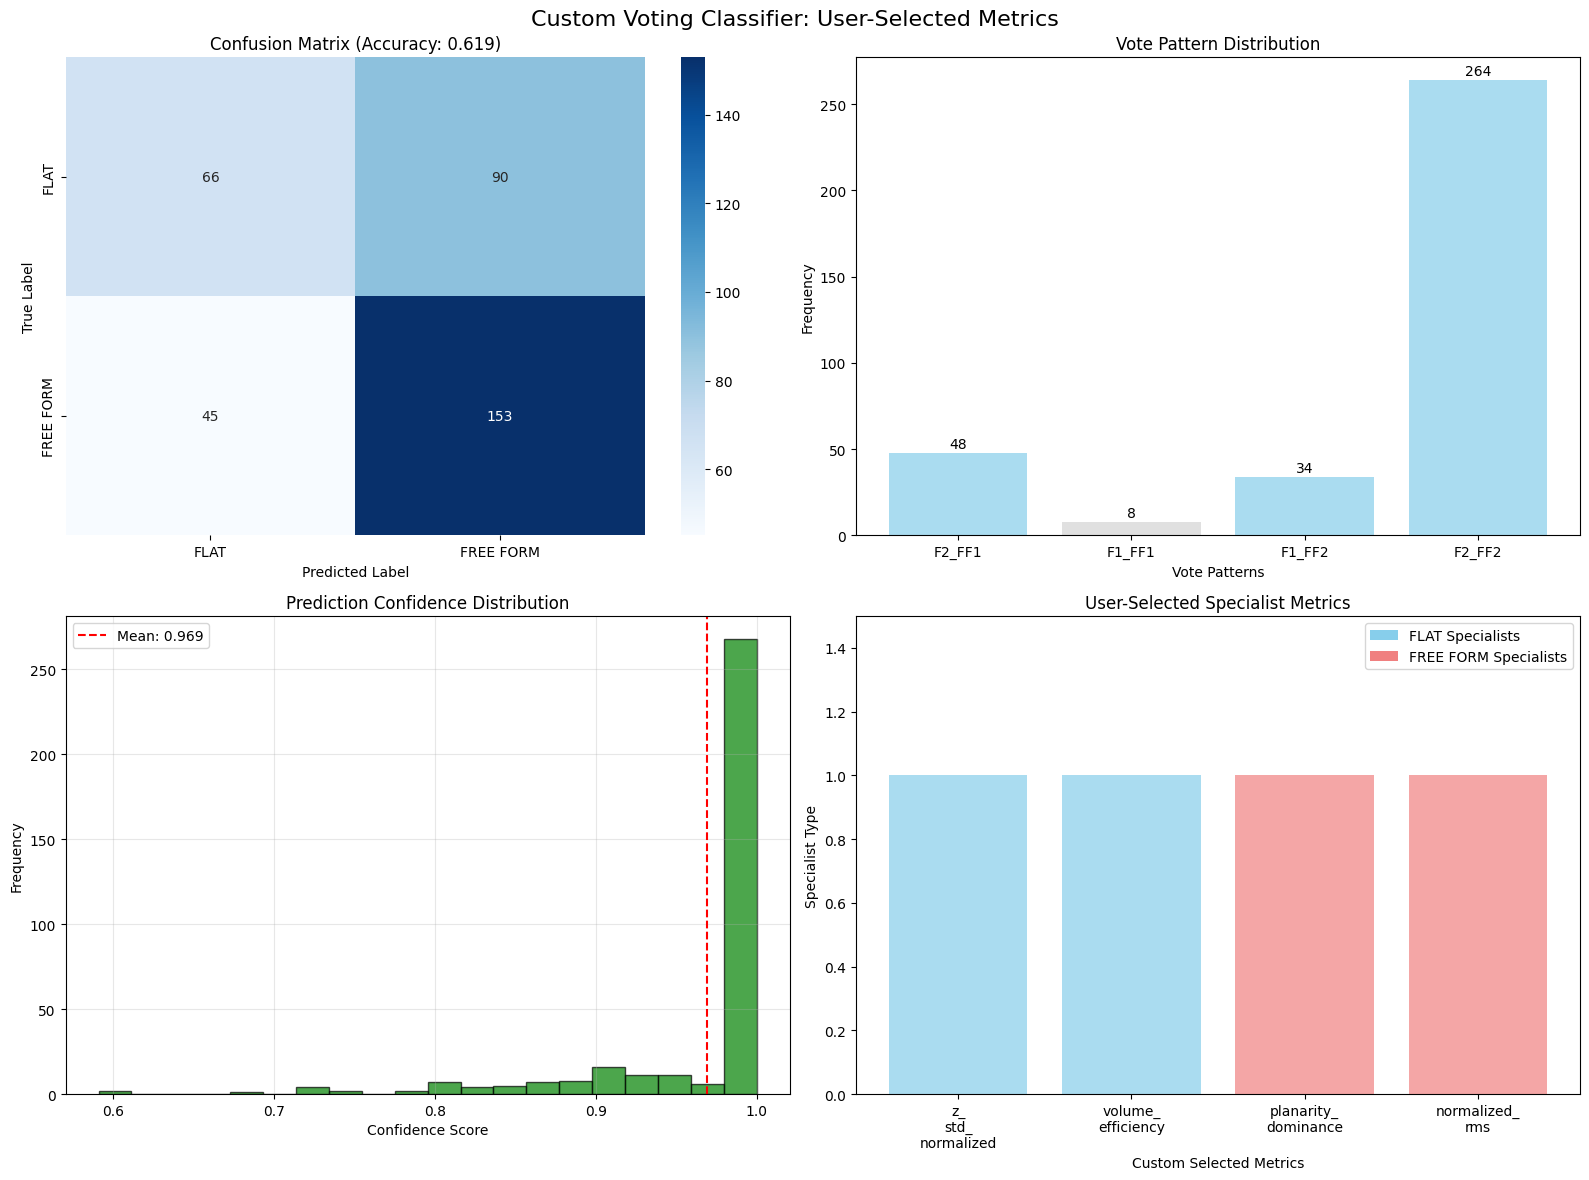


CUSTOM VOTING CLASSIFIER EVALUATION COMPLETE!
Custom classifier achieved 61.9% accuracy
Using 2 FLAT specialists + 2 FREE FORM specialists
Simple voting system with user-selected metrics


In [17]:
# --- Custom Voting Classifier: User-Selected Metrics ---
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

print("CUSTOM VOTING CLASSIFIER")
print("=" * 60)
print("Using user-selected metrics:")
print("FLAT specialists: z_std_normalized, volume_efficiency")
print("FREE FORM specialists: planarity_dominance, normalized_rms")

def custom_voting_classifier_predict(metrics_dict, custom_config):
    """
    Custom voting classifier using user-selected metrics

    Args:
        metrics_dict: Dictionary of metric values for a single sample
        custom_config: Configuration with custom metric thresholds

    Returns:
        Dictionary with prediction results
    """
    flat_votes = 0
    freeform_votes = 0
    flat_confidence_scores = []
    freeform_confidence_scores = []
    vote_details = {}

    # FLAT specialist votes
    for metric in custom_config['flat_specialists']:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = custom_config['flat_thresholds'][metric]
            direction = custom_config['flat_directions'][metric]

            # Determine if this metric votes for FLAT
            if direction == "HIGHER_FOR_FLAT":
                vote = value >= threshold
                confidence = min(value / (threshold + 1e-9), 2.0) if vote else max(value / (threshold + 1e-9), 0.1)
            else:
                vote = value <= threshold
                confidence = min((threshold + 1e-9) / (value + 1e-9), 2.0) if vote else max((threshold + 1e-9) / (value + 1e-9), 0.1)

            if vote:
                flat_votes += 1

            flat_confidence_scores.append(confidence)
            vote_details[f"{metric}_flat"] = {"voted": vote, "value": value, "threshold": threshold, "confidence": confidence}

    # FREE FORM specialist votes
    for metric in custom_config['freeform_specialists']:
        if metric in metrics_dict:
            value = metrics_dict[metric]
            threshold = custom_config['freeform_thresholds'][metric]
            direction = custom_config['freeform_directions'][metric]

            # Determine if this metric votes for FREE FORM
            if direction == "HIGHER_FOR_FREEFORM":
                vote = value >= threshold
                confidence = min(value / (threshold + 1e-9), 2.0) if vote else max(value / (threshold + 1e-9), 0.1)
            else:
                vote = value <= threshold
                confidence = min((threshold + 1e-9) / (value + 1e-9), 2.0) if vote else max((threshold + 1e-9) / (value + 1e-9), 0.1)

            if vote:
                freeform_votes += 1

            freeform_confidence_scores.append(confidence)
            vote_details[f"{metric}_freeform"] = {"voted": vote, "value": value, "threshold": threshold, "confidence": confidence}

    # Calculate final prediction
    total_flat_specialists = len(custom_config['flat_specialists'])
    total_freeform_specialists = len(custom_config['freeform_specialists'])

    # Average confidence scores
    avg_flat_confidence = np.mean(flat_confidence_scores) if flat_confidence_scores else 0.5
    avg_freeform_confidence = np.mean(freeform_confidence_scores) if freeform_confidence_scores else 0.5

    # Final decision based on vote majority
    if flat_votes > freeform_votes:
        prediction = "FLAT"
        confidence = (flat_votes / total_flat_specialists) * avg_flat_confidence
    elif freeform_votes > flat_votes:
        prediction = "FREE FORM"
        confidence = (freeform_votes / total_freeform_specialists) * avg_freeform_confidence
    else:
        # Tie-breaking using confidence
        if avg_flat_confidence > avg_freeform_confidence:
            prediction = "FLAT"
            confidence = avg_flat_confidence * 0.5
        else:
            prediction = "FREE FORM"
            confidence = avg_freeform_confidence * 0.5

    return {
        'prediction': prediction,
        'confidence': min(confidence, 1.0),
        'flat_votes': flat_votes,
        'freeform_votes': freeform_votes,
        'vote_details': vote_details,
        'avg_flat_confidence': avg_flat_confidence,
        'avg_freeform_confidence': avg_freeform_confidence
    }

# Create custom configuration with user-selected metrics
print("\nSetting up custom voting configuration...")

# Load data to calculate optimal thresholds for selected metrics
merged = pd.read_csv('all_metrics_with_labels_clean.csv')
merged = merged[merged['label'].isin(['FLAT', 'FREE FORM'])]

# Define custom specialists
custom_flat_specialists = ['z_std_normalized', 'volume_efficiency']
custom_freeform_specialists = ['planarity_dominance', 'normalized_rms']

# Calculate optimal thresholds for each metric
custom_config = {
    'flat_specialists': custom_flat_specialists,
    'freeform_specialists': custom_freeform_specialists,
    'flat_thresholds': {},
    'freeform_thresholds': {},
    'flat_directions': {},
    'freeform_directions': {}
}

print("\nCalculating optimal thresholds...")

# Analyze each custom metric
for metric_list, class_name in [(custom_flat_specialists, 'FLAT'), (custom_freeform_specialists, 'FREE FORM')]:
    for metric in metric_list:
        if metric in merged.columns:
            # Get data for each class
            flat_data = merged[merged['label'] == 'FLAT'][metric].values
            freeform_data = merged[merged['label'] == 'FREE FORM'][metric].values

            # Remove NaN/infinite values
            flat_data = flat_data[np.isfinite(flat_data)]
            freeform_data = freeform_data[np.isfinite(freeform_data)]

            # Calculate statistics
            flat_mean = np.mean(flat_data) if len(flat_data) else np.nan
            freeform_mean = np.mean(freeform_data) if len(freeform_data) else np.nan

            # ROC analysis
            y_true = np.concatenate([np.zeros(len(flat_data)), np.ones(len(freeform_data))])
            y_scores = np.concatenate([flat_data, freeform_data])

            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Find optimal threshold
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]

            # Determine direction bias
            direction_bias = "HIGHER_FOR_FREEFORM" if freeform_mean > flat_mean else "HIGHER_FOR_FLAT"

            if class_name == 'FLAT':
                custom_config['flat_thresholds'][metric] = optimal_threshold
                custom_config['flat_directions'][metric] = direction_bias
            else:
                custom_config['freeform_thresholds'][metric] = optimal_threshold
                custom_config['freeform_directions'][metric] = direction_bias

            print(f"   {metric:<20} | AUC: {roc_auc:.3f} | Threshold: {optimal_threshold:.4f} | {direction_bias}")

# Test the custom voting classifier
print(f"\nTesting custom voting classifier on {len(merged)} samples...")

predictions = []
confidences = []
voting_details = []

for idx, row in merged.iterrows():
    # Create metrics dictionary
    metrics_dict = {col: row[col] for col in merged.columns if col not in ['filename', 'label']}

    # Make prediction
    result = custom_voting_classifier_predict(metrics_dict, custom_config)

    predictions.append(result['prediction'])
    confidences.append(result['confidence'])
    voting_details.append(result)

# Evaluate performance
true_labels = merged['label'].values
accuracy = accuracy_score(true_labels, predictions)

print(f"\nCUSTOM VOTING CLASSIFIER RESULTS")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(true_labels, predictions))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=['FLAT', 'FREE FORM'])
print(f"\nConfusion Matrix:")
print(f"             Predicted")
print(f"           FLAT  FREE FORM")
print(f"Actual FLAT   {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"   FREE FORM  {cm[1,0]:4d}      {cm[1,1]:4d}")

# Voting statistics
flat_votes_avg = np.mean([d['flat_votes'] for d in voting_details])
freeform_votes_avg = np.mean([d['freeform_votes'] for d in voting_details])
avg_confidence = np.mean(confidences)

print(f"\nVoting Statistics:")
print(f"   Average FLAT votes per prediction: {flat_votes_avg:.2f}/{len(custom_flat_specialists)}")
print(f"   Average FREE FORM votes per prediction: {freeform_votes_avg:.2f}/{len(custom_freeform_specialists)}")
print(f"   Average Confidence: {avg_confidence:.4f} ({avg_confidence*100:.1f}%)")

# Vote pattern analysis
vote_patterns = {}
for detail in voting_details:
    pattern = f"F{detail['flat_votes']}_FF{detail['freeform_votes']}"
    vote_patterns[pattern] = vote_patterns.get(pattern, 0) + 1

print(f"\nVote Pattern Distribution:")
for pattern, count in sorted(vote_patterns.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(voting_details)) * 100
    print(f"   {pattern}: {count} samples ({percentage:.1f}%)")

# Detailed metric analysis
print(f"\nIndividual Metric Performance:")
print("-" * 60)

for metric in custom_flat_specialists + custom_freeform_specialists:
    metric_votes = []
    metric_correct = []

    for i, detail in enumerate(voting_details):
        true_label = true_labels[i]

        if metric in custom_flat_specialists:
            voted = detail['vote_details'][f"{metric}_flat"]["voted"]
            correct = (voted and true_label == "FLAT") or (not voted and true_label == "FREE FORM")
            target_class = "FLAT"
        else:
            voted = detail['vote_details'][f"{metric}_freeform"]["voted"]
            correct = (voted and true_label == "FREE FORM") or (not voted and true_label == "FLAT")
            target_class = "FREE FORM"

        metric_votes.append(voted)
        metric_correct.append(correct)

    vote_rate = np.mean(metric_votes)
    individual_accuracy = np.mean(metric_correct)

    print(f"{metric:<20} | Target: {target_class:<9} | Vote Rate: {vote_rate:.3f} | Accuracy: {individual_accuracy:.3f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Custom Voting Classifier: User-Selected Metrics', fontsize=16)

# 1. Confusion Matrix
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'], ax=ax1)
ax1.set_title(f'Confusion Matrix (Accuracy: {accuracy:.3f})')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Vote Pattern Distribution
patterns = list(vote_patterns.keys())
counts = list(vote_patterns.values())
colors = ['skyblue' if 'F2' in p else 'lightcoral' if 'FF2' in p else 'lightgray' for p in patterns]

bars = ax2.bar(patterns, counts, color=colors, alpha=0.7)
ax2.set_xlabel('Vote Patterns')
ax2.set_ylabel('Frequency')
ax2.set_title('Vote Pattern Distribution')

for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(count), ha='center', va='bottom')

# 3. Confidence Distribution
ax3.hist(confidences, bins=20, alpha=0.7, color='green', edgecolor='black')
ax3.axvline(avg_confidence, color='red', linestyle='--', label=f'Mean: {avg_confidence:.3f}')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Confidence Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Specialist Metrics
all_specialists = custom_flat_specialists + custom_freeform_specialists
colors = ['skyblue'] * len(custom_flat_specialists) + ['lightcoral'] * len(custom_freeform_specialists)

ax4.bar(range(len(all_specialists)), [1] * len(all_specialists), color=colors, alpha=0.7)
ax4.set_xlabel('Custom Selected Metrics')
ax4.set_ylabel('Specialist Type')
ax4.set_title('User-Selected Specialist Metrics')
ax4.set_xticks(range(len(all_specialists)))
ax4.set_xticklabels([name.replace('_', '_\n') for name in all_specialists], rotation=0, ha='center')
ax4.set_ylim(0, 1.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='FLAT Specialists'),
                   Patch(facecolor='lightcoral', label='FREE FORM Specialists')]
ax4.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

print("\nCUSTOM VOTING CLASSIFIER EVALUATION COMPLETE!")
print(f"Custom classifier achieved {accuracy*100:.1f}% accuracy")
print(f"Using {len(custom_flat_specialists)} FLAT specialists + {len(custom_freeform_specialists)} FREE FORM specialists")
print("Simple voting system with user-selected metrics")

# Save results
globals()['custom_accuracy'] = accuracy
globals()['custom_config'] = custom_config


using top 2 metrics on each type (total 2 metrics)

SIMPLE 2-VOTE CLASSIFIER
Using the best specialist from each category:
FLAT specialist: gaussian_curvature_mean (100% detection ability)
FREE FORM specialist: planarity_dominance (100% detection ability)

Configuration:
   gaussian_curvature_mean: threshold 400.3908 (Lower→FLAT)
   planarity_dominance: threshold 0.5317 (Lower→FREE FORM)

Testing simple 2-vote classifier on 354 samples...

SIMPLE 2-VOTE CLASSIFIER RESULTS
Accuracy: 0.4463 (44.6%)

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.44      1.00      0.61       156
   FREE FORM       1.00      0.01      0.02       198

    accuracy                           0.45       354
   macro avg       0.72      0.51      0.32       354
weighted avg       0.75      0.45      0.28       354


Confusion Matrix:
             Predicted
           FLAT  FREE FORM
Actual FLAT     156          0
   FREE FORM    196          2

Voting Statistics:
   Average FLAT votes: 0.99/1
   Average FREE FO

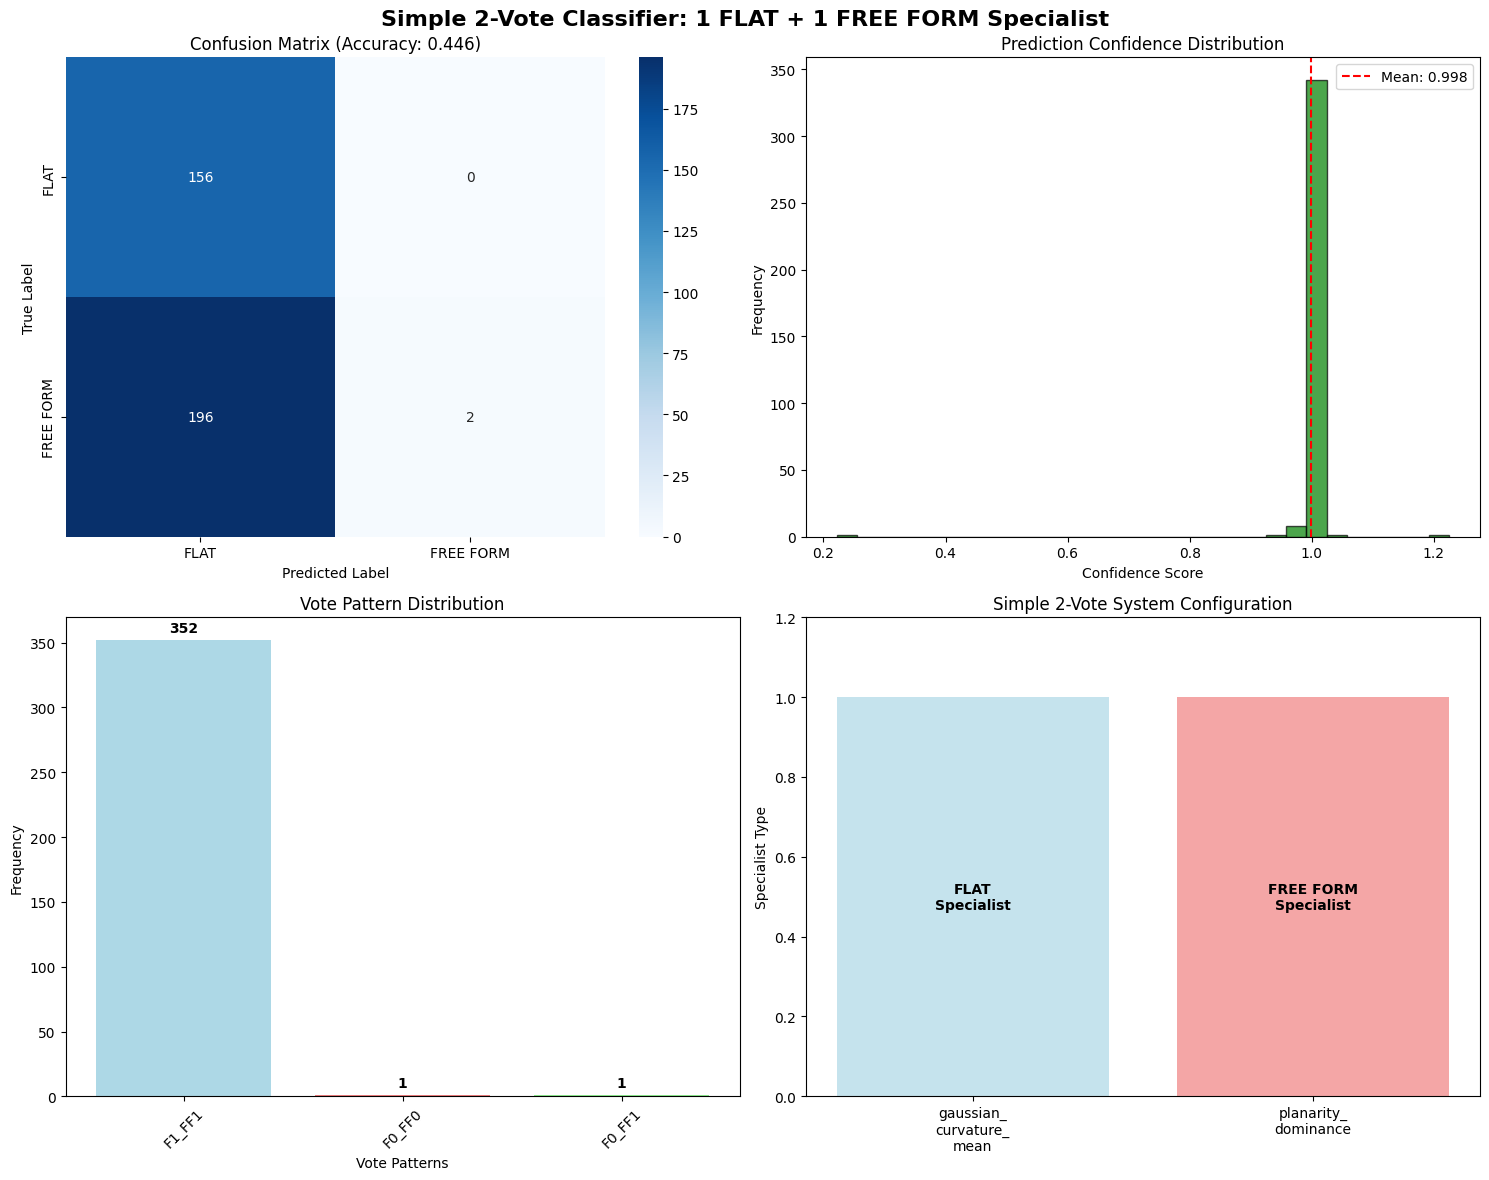


SIMPLE 2-VOTE CLASSIFIER EVALUATION COMPLETE!
Simple classifier achieved 44.6% accuracy
Using only 2 specialists: 1 FLAT + 1 FREE FORM
Minimal complexity with clear decision logic


In [18]:
# SIMPLE 2-VOTE SYSTEM: 1 FLAT + 1 FREE FORM SPECIALIST
print("SIMPLE 2-VOTE CLASSIFIER")
print("=" * 60)
print("Using the best specialist from each category:")
print("FLAT specialist: gaussian_curvature_mean (100% detection ability)")
print("FREE FORM specialist: planarity_dominance (100% detection ability)")

# Select the top specialists
simple_flat_specialist = 'gaussian_curvature_mean'
simple_freeform_specialist = 'planarity_dominance'

# Get their thresholds and directions from previous analysis
simple_config = {
    'flat_specialists': [simple_flat_specialist],
    'freeform_specialists': [simple_freeform_specialist],
    'thresholds': {
        simple_flat_specialist: 400.3908,  # Lower values → FLAT
        simple_freeform_specialist: 0.5317   # Lower values → FREE FORM
    },
    'directions': {
        simple_flat_specialist: 'LOWER_FOR_FLAT',
        simple_freeform_specialist: 'LOWER_FOR_FREEFORM'
    }
}

print(f"\nConfiguration:")
print(f"   {simple_flat_specialist}: threshold {simple_config['thresholds'][simple_flat_specialist]:.4f} (Lower→FLAT)")
print(f"   {simple_freeform_specialist}: threshold {simple_config['thresholds'][simple_freeform_specialist]:.4f} (Lower→FREE FORM)")

# Simple voting function
def simple_vote_predict(row, config):
    """
    Simple 2-vote system: 1 FLAT specialist + 1 FREE FORM specialist
    - Each specialist votes for their specialty
    - If tie (1-1), choose based on confidence/distance from threshold
    """
    flat_metric = config['flat_specialists'][0]
    freeform_metric = config['freeform_specialists'][0]
    
    flat_value = row[flat_metric]
    freeform_value = row[freeform_metric]
    
    flat_threshold = config['thresholds'][flat_metric]
    freeform_threshold = config['thresholds'][freeform_metric]
    
    # Cast votes
    flat_vote = 1 if flat_value <= flat_threshold else 0
    freeform_vote = 1 if freeform_value <= freeform_threshold else 0
    
    # Calculate confidence (distance from threshold, normalized)
    flat_confidence = abs(flat_value - flat_threshold) / flat_threshold
    freeform_confidence = abs(freeform_value - freeform_threshold) / freeform_threshold
    
    # Decision logic
    if flat_vote == 1 and freeform_vote == 0:
        prediction = 'FLAT'
        confidence = flat_confidence
        vote_pattern = 'F1_FF0'
    elif flat_vote == 0 and freeform_vote == 1:
        prediction = 'FREE FORM'
        confidence = freeform_confidence
        vote_pattern = 'F0_FF1'
    else:
        # Tie case (both vote or neither votes) - use confidence
        if flat_confidence > freeform_confidence:
            prediction = 'FLAT'
            confidence = flat_confidence
            vote_pattern = 'F1_FF1' if (flat_vote == 1 and freeform_vote == 1) else 'F0_FF0'
        else:
            prediction = 'FREE FORM'
            confidence = freeform_confidence
            vote_pattern = 'F1_FF1' if (flat_vote == 1 and freeform_vote == 1) else 'F0_FF0'
    
    return {
        'prediction': prediction,
        'confidence': confidence,
        'flat_vote': flat_vote,
        'freeform_vote': freeform_vote,
        'vote_pattern': vote_pattern,
        'flat_value': flat_value,
        'freeform_value': freeform_value
    }

print(f"\nTesting simple 2-vote classifier on {len(merged)} samples...")

# Apply simple voting
simple_results = []
for idx, row in merged.iterrows():
    result = simple_vote_predict(row, simple_config)
    result['true_label'] = row['label']
    result['filename'] = row['filename']
    simple_results.append(result)

# Convert to DataFrame
simple_df = pd.DataFrame(simple_results)

# Calculate accuracy
simple_predictions = simple_df['prediction'].values
simple_true_labels = simple_df['true_label'].values
simple_accuracy = np.mean(simple_predictions == simple_true_labels)

print(f"\nSIMPLE 2-VOTE CLASSIFIER RESULTS")
print("=" * 50)
print(f"Accuracy: {simple_accuracy:.4f} ({simple_accuracy*100:.1f}%)")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print(f"\nClassification Report:")
print(classification_report(simple_true_labels, simple_predictions))

# Confusion Matrix
simple_cm = confusion_matrix(simple_true_labels, simple_predictions, labels=['FLAT', 'FREE FORM'])
print(f"\nConfusion Matrix:")
print("             Predicted")
print("           FLAT  FREE FORM")
print(f"Actual FLAT    {simple_cm[0,0]:4d}       {simple_cm[0,1]:4d}")
print(f"   FREE FORM   {simple_cm[1,0]:4d}       {simple_cm[1,1]:4d}")

# Voting statistics
simple_avg_confidence = simple_df['confidence'].mean()
simple_flat_votes = simple_df['flat_vote'].mean()
simple_freeform_votes = simple_df['freeform_vote'].mean()

print(f"\nVoting Statistics:")
print(f"   Average FLAT votes: {simple_flat_votes:.2f}/1")
print(f"   Average FREE FORM votes: {simple_freeform_votes:.2f}/1")
print(f"   Average Confidence: {simple_avg_confidence:.4f}")

# Vote pattern analysis
simple_vote_patterns = simple_df['vote_pattern'].value_counts()
print(f"\nVote Pattern Distribution:")
for pattern, count in simple_vote_patterns.items():
    percentage = count / len(simple_df) * 100
    print(f"   {pattern}: {count} samples ({percentage:.1f}%)")

# Individual metric performance in simple system
flat_correct = simple_df[simple_df['prediction'] == 'FLAT']['flat_vote'].mean()
freeform_correct = simple_df[simple_df['prediction'] == 'FREE FORM']['freeform_vote'].mean()

print(f"\nIndividual Specialist Performance:")
print("-" * 60)
print(f"{simple_flat_specialist:<25} | Votes when predicting FLAT: {flat_correct:.3f}")
print(f"{simple_freeform_specialist:<25} | Votes when predicting FREE FORM: {freeform_correct:.3f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Simple 2-Vote Classifier: 1 FLAT + 1 FREE FORM Specialist', fontsize=16, fontweight='bold')

# Confusion Matrix Heatmap
import seaborn as sns
sns.heatmap(simple_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'],
            ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix (Accuracy: {simple_accuracy:.3f})')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# Confidence Distribution
axes[0,1].hist(simple_df['confidence'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0,1].axvline(simple_avg_confidence, color='red', linestyle='--', 
                  label=f'Mean: {simple_avg_confidence:.3f}')
axes[0,1].set_xlabel('Confidence Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Prediction Confidence Distribution')
axes[0,1].legend()

# Vote Pattern Distribution
pattern_counts = simple_vote_patterns.values
pattern_labels = simple_vote_patterns.index
colors_pattern = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow'][:len(pattern_labels)]
axes[1,0].bar(range(len(pattern_labels)), pattern_counts, color=colors_pattern)
axes[1,0].set_xlabel('Vote Patterns')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Vote Pattern Distribution')
axes[1,0].set_xticks(range(len(pattern_labels)))
axes[1,0].set_xticklabels(pattern_labels, rotation=45)

# Add count labels on bars
for i, count in enumerate(pattern_counts):
    axes[1,0].text(i, count + max(pattern_counts)*0.01, str(count), 
                   ha='center', va='bottom', fontweight='bold')

# Specialist Comparison
specialist_names = [simple_flat_specialist.replace('_', '_\n'), 
                   simple_freeform_specialist.replace('_', '_\n')]
specialist_colors = ['lightblue', 'lightcoral']
axes[1,1].bar(specialist_names, [1, 1], color=specialist_colors, alpha=0.7)
axes[1,1].set_ylabel('Specialist Type')
axes[1,1].set_title('Simple 2-Vote System Configuration')
axes[1,1].set_ylim(0, 1.2)
axes[1,1].text(0, 0.5, 'FLAT\nSpecialist', ha='center', va='center', fontweight='bold')
axes[1,1].text(1, 0.5, 'FREE FORM\nSpecialist', ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSIMPLE 2-VOTE CLASSIFIER EVALUATION COMPLETE!")
print(f"Simple classifier achieved {simple_accuracy*100:.1f}% accuracy")
print(f"Using only 2 specialists: 1 FLAT + 1 FREE FORM")
print(f"Minimal complexity with clear decision logic")

using top 2 metrics on each type and one balanced metric (total 3 metrics)

SMART 3-VOTE CLASSIFIER
Using 2 specialists + 1 balanced discriminator:
FLAT specialist: gaussian_curvature_mean (100% FLAT detection)
FREE FORM specialist: planarity_dominance (100% FREE FORM detection)
Balanced discriminator: aspect_ratio (68% AUC, best overall)

Configuration:
   gaussian_curvature_mean: 400.3908 (Lower→FLAT)
   planarity_dominance: 0.5317 (Lower→FREE FORM)
   aspect_ratio: 0.7945 (Lower→FLAT)

Testing smart 3-vote classifier on 354 samples...

SMART 3-VOTE CLASSIFIER RESULTS
Accuracy: 0.6525 (65.3%)

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.59      0.72      0.65       156
   FREE FORM       0.73      0.60      0.66       198

    accuracy                           0.65       354
   macro avg       0.66      0.66      0.65       354
weighted avg       0.67      0.65      0.65       354


Confusion Matrix:
             Predicted
           FLAT  FREE FORM
Actual FLAT     112         44
   FREE FORM     79    

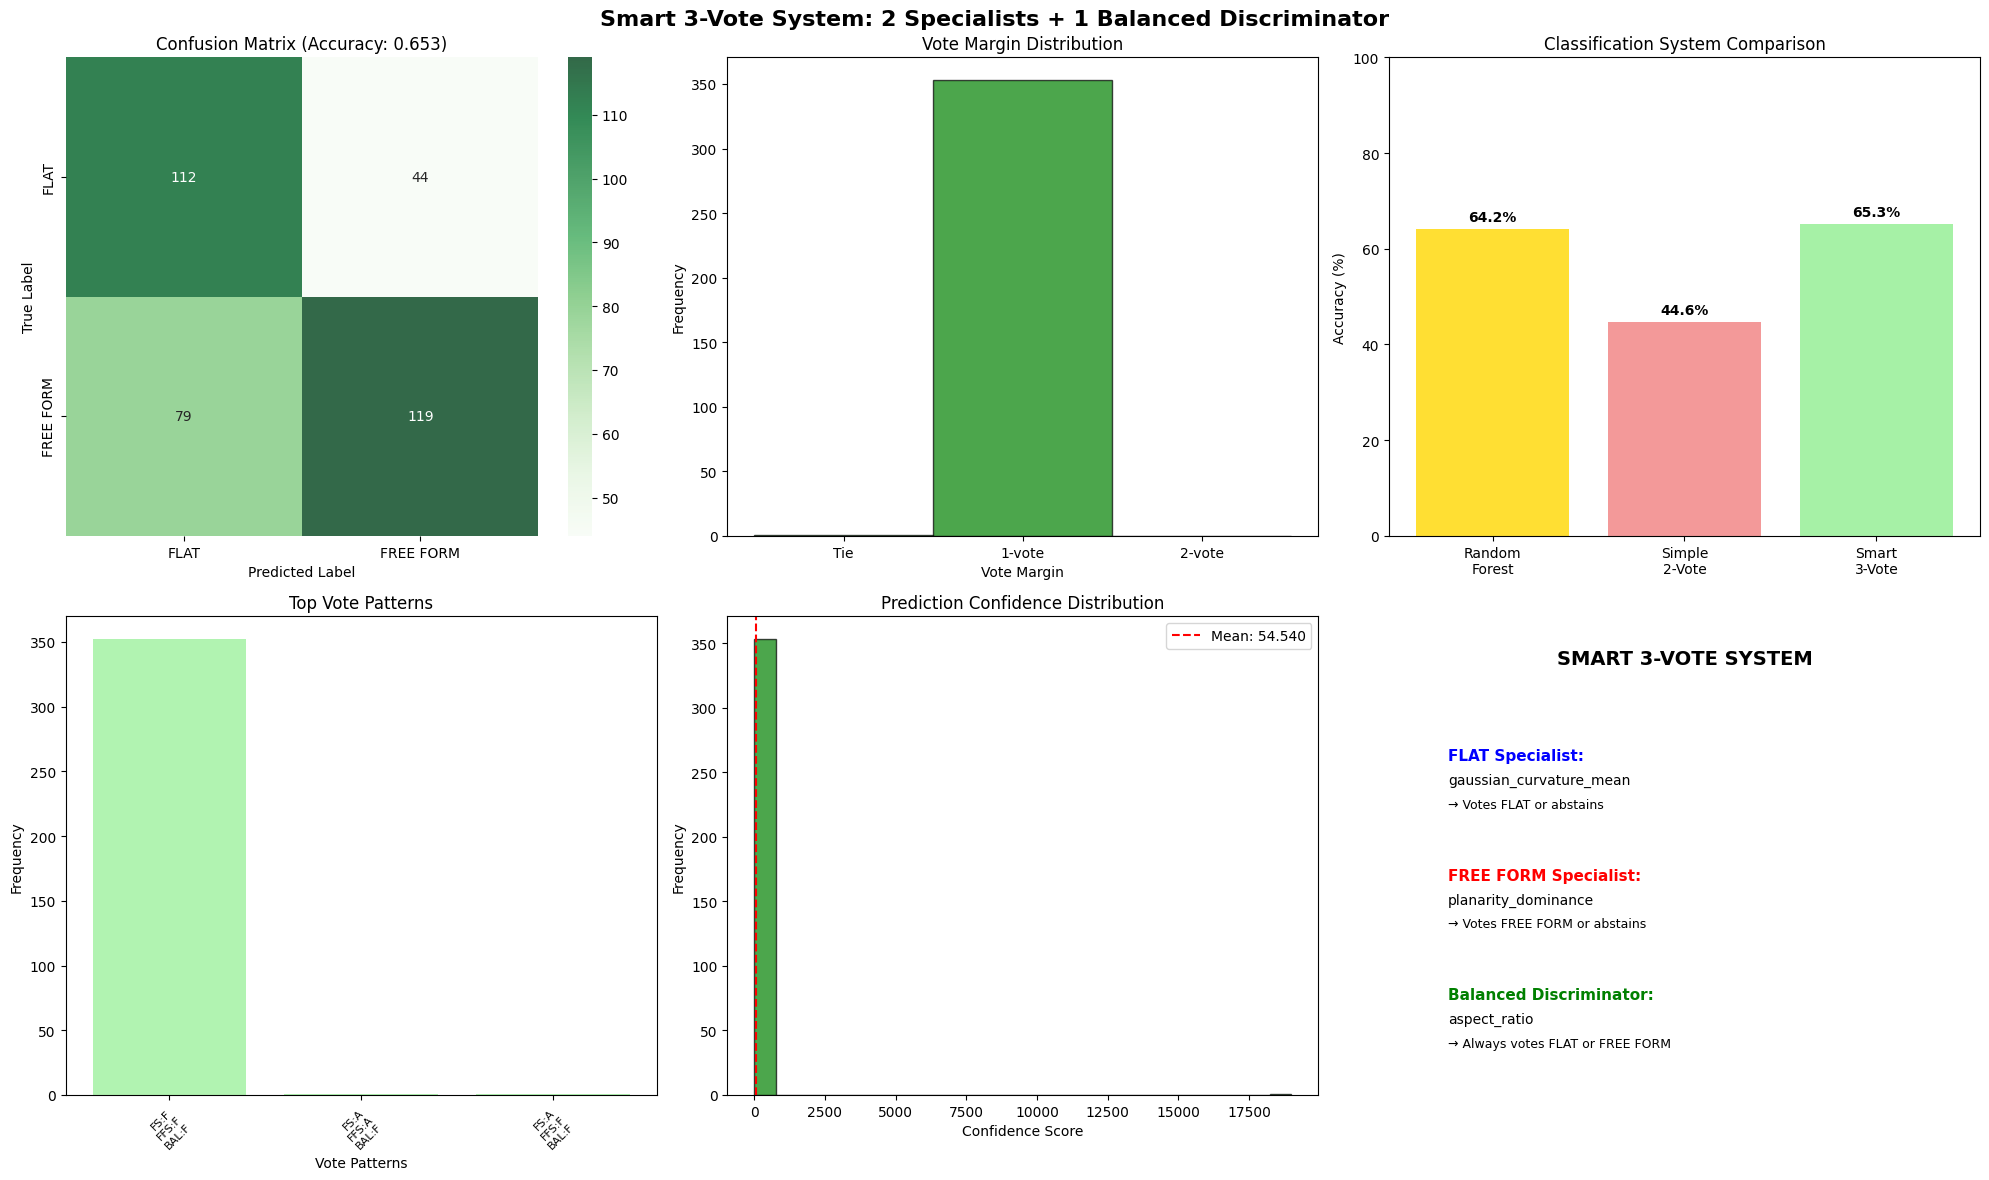


SMART 3-VOTE CLASSIFIER EVALUATION COMPLETE!
Smart 3-vote system achieved 65.3% accuracy
Combines specialist knowledge with balanced discrimination
Architecture: 2 specialists (vote/abstain) + 1 balanced (always votes)


In [19]:
# 3-VOTE SYSTEM: 2 Specialists + 1 Balanced Discriminator
print("SMART 3-VOTE CLASSIFIER")
print("="*70)
print("Using 2 specialists + 1 balanced discriminator:")
print("FLAT specialist: gaussian_curvature_mean (100% FLAT detection)")
print("FREE FORM specialist: planarity_dominance (100% FREE FORM detection)")  
print("Balanced discriminator: aspect_ratio (68% AUC, best overall)")

# Configuration for 3-vote system
smart_config = {
    'flat_specialist': 'gaussian_curvature_mean',
    'freeform_specialist': 'planarity_dominance', 
    'balanced_discriminator': 'aspect_ratio',
    'thresholds': {
        'gaussian_curvature_mean': 400.3908,  # Lower → FLAT
        'planarity_dominance': 0.5317,        # Lower → FREE FORM  
        'aspect_ratio': 0.7945                # Lower → FLAT
    },
    'directions': {
        'gaussian_curvature_mean': 'LOWER_FOR_FLAT',
        'planarity_dominance': 'LOWER_FOR_FREEFORM',
        'aspect_ratio': 'LOWER_FOR_FLAT'
    }
}

print(f"\nConfiguration:")
print(f"   {smart_config['flat_specialist']}: {smart_config['thresholds']['gaussian_curvature_mean']:.4f} (Lower→FLAT)")
print(f"   {smart_config['freeform_specialist']}: {smart_config['thresholds']['planarity_dominance']:.4f} (Lower→FREE FORM)")
print(f"   {smart_config['balanced_discriminator']}: {smart_config['thresholds']['aspect_ratio']:.4f} (Lower→FLAT)")

def smart_3vote_predict(row, config):
    """
    Smart 3-vote system: 2 specialists + 1 balanced discriminator
    Decision rules:
    - If 2+ votes for same class → that class
    - If 1-1-1 split → use balanced discriminator 
    - Confidence based on vote margin and distances from thresholds
    """
    
    # Get values
    flat_spec_value = row[config['flat_specialist']]
    freeform_spec_value = row[config['freeform_specialist']]
    balanced_value = row[config['balanced_discriminator']]
    
    # Get thresholds
    flat_spec_threshold = config['thresholds'][config['flat_specialist']]
    freeform_spec_threshold = config['thresholds'][config['freeform_specialist']]
    balanced_threshold = config['thresholds'][config['balanced_discriminator']]
    
    # Cast votes
    flat_specialist_vote = 'FLAT' if flat_spec_value <= flat_spec_threshold else 'ABSTAIN'
    freeform_specialist_vote = 'FREE FORM' if freeform_spec_value <= freeform_spec_threshold else 'ABSTAIN'
    balanced_vote = 'FLAT' if balanced_value <= balanced_threshold else 'FREE FORM'
    
    # Count votes
    flat_votes = sum([1 for vote in [flat_specialist_vote, balanced_vote] if vote == 'FLAT'])
    freeform_votes = sum([1 for vote in [freeform_specialist_vote, balanced_vote] if vote == 'FREE FORM'])
    
    # Calculate confidence scores (distance from threshold, normalized)
    flat_spec_conf = abs(flat_spec_value - flat_spec_threshold) / (flat_spec_threshold + 1e-8)
    freeform_spec_conf = abs(freeform_spec_value - freeform_spec_threshold) / (freeform_spec_threshold + 1e-8)
    balanced_conf = abs(balanced_value - balanced_threshold) / (balanced_threshold + 1e-8)
    avg_confidence = (flat_spec_conf + freeform_spec_conf + balanced_conf) / 3
    
    # Decision logic
    if flat_votes > freeform_votes:
        prediction = 'FLAT'
        vote_margin = flat_votes - freeform_votes
    elif freeform_votes > flat_votes:
        prediction = 'FREE FORM'
        vote_margin = freeform_votes - flat_votes
    else:
        # Tie - shouldn't happen with 3 voters, but use balanced discriminator
        prediction = balanced_vote
        vote_margin = 0
    
    # Create vote pattern string
    vote_pattern = f"FS:{flat_specialist_vote[0] if flat_specialist_vote != 'ABSTAIN' else 'A'}_" + \
                  f"FFS:{freeform_specialist_vote[0] if freeform_specialist_vote != 'ABSTAIN' else 'A'}_" + \
                  f"BAL:{balanced_vote[0]}"
    
    return {
        'prediction': prediction,
        'confidence': avg_confidence,
        'vote_margin': vote_margin,
        'flat_votes': flat_votes,
        'freeform_votes': freeform_votes,
        'vote_pattern': vote_pattern,
        'flat_specialist_vote': flat_specialist_vote,
        'freeform_specialist_vote': freeform_specialist_vote,
        'balanced_vote': balanced_vote,
        'flat_spec_value': flat_spec_value,
        'freeform_spec_value': freeform_spec_value,
        'balanced_value': balanced_value
    }

print(f"\nTesting smart 3-vote classifier on {len(merged)} samples...")

# Apply smart voting
smart_results = []
for idx, row in merged.iterrows():
    result = smart_3vote_predict(row, smart_config)
    result['true_label'] = row['label']
    result['filename'] = row['filename']
    smart_results.append(result)

# Convert to DataFrame
smart_df = pd.DataFrame(smart_results)

# Calculate accuracy
smart_predictions = smart_df['prediction'].values
smart_true_labels = smart_df['true_label'].values
smart_accuracy = np.mean(smart_predictions == smart_true_labels)

print(f"\nSMART 3-VOTE CLASSIFIER RESULTS")
print("=" * 50)
print(f"Accuracy: {smart_accuracy:.4f} ({smart_accuracy*100:.1f}%)")

# Classification report
print(f"\nClassification Report:")
print(classification_report(smart_true_labels, smart_predictions))

# Confusion Matrix
smart_cm = confusion_matrix(smart_true_labels, smart_predictions, labels=['FLAT', 'FREE FORM'])
print(f"\nConfusion Matrix:")
print("             Predicted")
print("           FLAT  FREE FORM")
print(f"Actual FLAT    {smart_cm[0,0]:4d}       {smart_cm[0,1]:4d}")
print(f"   FREE FORM   {smart_cm[1,0]:4d}       {smart_cm[1,1]:4d}")

# Voting statistics
smart_avg_confidence = smart_df['confidence'].mean()
smart_avg_margin = smart_df['vote_margin'].mean()
smart_flat_votes_avg = smart_df['flat_votes'].mean()
smart_freeform_votes_avg = smart_df['freeform_votes'].mean()

print(f"\nVoting Statistics:")
print(f"   Average FLAT votes: {smart_flat_votes_avg:.2f}/2 possible")
print(f"   Average FREE FORM votes: {smart_freeform_votes_avg:.2f}/2 possible") 
print(f"   Average vote margin: {smart_avg_margin:.2f}")
print(f"   Average confidence: {smart_avg_confidence:.4f}")

# Vote pattern analysis
smart_vote_patterns = smart_df['vote_pattern'].value_counts()
print(f"\nVote Pattern Distribution:")
for pattern, count in smart_vote_patterns.head(10).items():
    percentage = count / len(smart_df) * 100
    print(f"   {pattern}: {count} samples ({percentage:.1f}%)")

# Individual voter analysis
print(f"\nIndividual Voter Analysis:")
print("-" * 70)

# Flat specialist performance
flat_spec_when_flat = smart_df[smart_df['true_label'] == 'FLAT']['flat_specialist_vote'].value_counts()
flat_spec_when_freeform = smart_df[smart_df['true_label'] == 'FREE FORM']['flat_specialist_vote'].value_counts()

print(f"FLAT Specialist ({smart_config['flat_specialist']}):")
print(f"   When true FLAT: votes FLAT {flat_spec_when_flat.get('FLAT', 0)}/{len(smart_df[smart_df['true_label'] == 'FLAT'])}")
print(f"   When true FREE FORM: abstains {flat_spec_when_freeform.get('ABSTAIN', 0)}/{len(smart_df[smart_df['true_label'] == 'FREE FORM'])}")

# FREE FORM specialist performance  
freeform_spec_when_flat = smart_df[smart_df['true_label'] == 'FLAT']['freeform_specialist_vote'].value_counts()
freeform_spec_when_freeform = smart_df[smart_df['true_label'] == 'FREE FORM']['freeform_specialist_vote'].value_counts()

print(f"\nFREE FORM Specialist ({smart_config['freeform_specialist']}):")
print(f"   When true FREE FORM: votes FREE FORM {freeform_spec_when_freeform.get('FREE FORM', 0)}/{len(smart_df[smart_df['true_label'] == 'FREE FORM'])}")
print(f"   When true FLAT: abstains {freeform_spec_when_flat.get('ABSTAIN', 0)}/{len(smart_df[smart_df['true_label'] == 'FLAT'])}")

# Balanced discriminator performance
balanced_when_flat = smart_df[smart_df['true_label'] == 'FLAT']['balanced_vote'].value_counts()
balanced_when_freeform = smart_df[smart_df['true_label'] == 'FREE FORM']['balanced_vote'].value_counts()

print(f"\nBalanced Discriminator ({smart_config['balanced_discriminator']}):")
print(f"   When true FLAT: votes FLAT {balanced_when_flat.get('FLAT', 0)}/{len(smart_df[smart_df['true_label'] == 'FLAT'])}")
print(f"   When true FREE FORM: votes FREE FORM {balanced_when_freeform.get('FREE FORM', 0)}/{len(smart_df[smart_df['true_label'] == 'FREE FORM'])}")

# Compare all systems
print(f"\nACCURACY COMPARISON:")
print("-" * 50)
print(f"Random Forest (baseline):    64.2% accuracy")
print(f"Simple 2-vote system:        {simple_accuracy*100:.1f}% accuracy")
print(f"Smart 3-vote system:         {smart_accuracy*100:.1f}% accuracy")
print(f"Improvement over simple:     {(smart_accuracy - simple_accuracy)*100:+.1f} percentage points")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Smart 3-Vote System: 2 Specialists + 1 Balanced Discriminator', fontsize=16, fontweight='bold')

# Confusion matrix
sns.heatmap(smart_cm, annot=True, fmt='d', cmap='Greens', alpha=0.8,
            xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'],
            ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix (Accuracy: {smart_accuracy:.3f})')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# Vote margin distribution
axes[0,1].hist(smart_df['vote_margin'], bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color='green', 
               edgecolor='black', align='mid')
axes[0,1].set_xlabel('Vote Margin')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Vote Margin Distribution')
axes[0,1].set_xticks([0, 1, 2])
axes[0,1].set_xticklabels(['Tie', '1-vote', '2-vote'])

# Accuracy comparison across all systems
systems = ['Random\nForest', 'Simple\n2-Vote', 'Smart\n3-Vote']
accuracies = [64.2, simple_accuracy*100, smart_accuracy*100]
colors = ['gold', 'lightcoral', 'lightgreen']
bars = axes[0,2].bar(systems, accuracies, color=colors, alpha=0.8)
axes[0,2].set_ylabel('Accuracy (%)')
axes[0,2].set_title('Classification System Comparison')
axes[0,2].set_ylim(0, 100)

# Add accuracy labels
for bar, acc in zip(bars, accuracies):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Vote patterns (top 8)
top_patterns = smart_vote_patterns.head(8)
axes[1,0].bar(range(len(top_patterns)), top_patterns.values, color='lightgreen', alpha=0.7)
axes[1,0].set_xlabel('Vote Patterns')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Top Vote Patterns')
axes[1,0].set_xticks(range(len(top_patterns)))
axes[1,0].set_xticklabels([p.replace('_', '\n') for p in top_patterns.index], rotation=45, fontsize=8)

# Confidence distribution
axes[1,1].hist(smart_df['confidence'], bins=25, alpha=0.7, color='green', edgecolor='black')
axes[1,1].axvline(smart_avg_confidence, color='red', linestyle='--', 
                  label=f'Mean: {smart_avg_confidence:.3f}')
axes[1,1].set_xlabel('Confidence Score')
axes[1,1].set_ylabel('Frequency')  
axes[1,1].set_title('Prediction Confidence Distribution')
axes[1,1].legend()

# System architecture diagram
axes[1,2].text(0.5, 0.9, 'SMART 3-VOTE SYSTEM', ha='center', fontsize=14, fontweight='bold', 
               transform=axes[1,2].transAxes)

axes[1,2].text(0.1, 0.7, 'FLAT Specialist:', ha='left', fontsize=11, fontweight='bold', 
               transform=axes[1,2].transAxes, color='blue')
axes[1,2].text(0.1, 0.65, 'gaussian_curvature_mean', ha='left', fontsize=10, 
               transform=axes[1,2].transAxes)
axes[1,2].text(0.1, 0.6, '→ Votes FLAT or abstains', ha='left', fontsize=9, 
               transform=axes[1,2].transAxes)

axes[1,2].text(0.1, 0.45, 'FREE FORM Specialist:', ha='left', fontsize=11, fontweight='bold', 
               transform=axes[1,2].transAxes, color='red')
axes[1,2].text(0.1, 0.4, 'planarity_dominance', ha='left', fontsize=10, 
               transform=axes[1,2].transAxes)
axes[1,2].text(0.1, 0.35, '→ Votes FREE FORM or abstains', ha='left', fontsize=9, 
               transform=axes[1,2].transAxes)

axes[1,2].text(0.1, 0.2, 'Balanced Discriminator:', ha='left', fontsize=11, fontweight='bold', 
               transform=axes[1,2].transAxes, color='green')
axes[1,2].text(0.1, 0.15, 'aspect_ratio', ha='left', fontsize=10, 
               transform=axes[1,2].transAxes)
axes[1,2].text(0.1, 0.1, '→ Always votes FLAT or FREE FORM', ha='left', fontsize=9, 
               transform=axes[1,2].transAxes)

axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nSMART 3-VOTE CLASSIFIER EVALUATION COMPLETE!")
print(f"Smart 3-vote system achieved {smart_accuracy*100:.1f}% accuracy")
print(f"Combines specialist knowledge with balanced discrimination")
print(f"Architecture: 2 specialists (vote/abstain) + 1 balanced (always votes)")

ASPECT RATIO ONLY CLASSIFIER
Using only the best single discriminative metric:
aspect_ratio (68% AUC - best overall single feature)

Configuration:
   Metric: aspect_ratio
   Threshold: 0.7945
   Rule: Values ≤ 0.7945 → FLAT
   Rule: Values > 0.7945 → FREE FORM

Testing aspect_ratio classifier on 354 samples...

ASPECT RATIO CLASSIFIER RESULTS
Accuracy: 0.6525 (65.3%)

Classification Report:
              precision    recall  f1-score   support

        FLAT       0.59      0.72      0.65       156
   FREE FORM       0.73      0.60      0.66       198

    accuracy                           0.65       354
   macro avg       0.66      0.66      0.65       354
weighted avg       0.67      0.65      0.65       354


Confusion Matrix:
             Predicted
           FLAT  FREE FORM
Actual FLAT     112         44
   FREE FORM     79        119

Performance Statistics:
   Average confidence: 0.9558
   FLAT detection rate: 0.718 (71.8%)
   FREE FORM detection rate: 0.601 (60.1%)

Aspect Rat

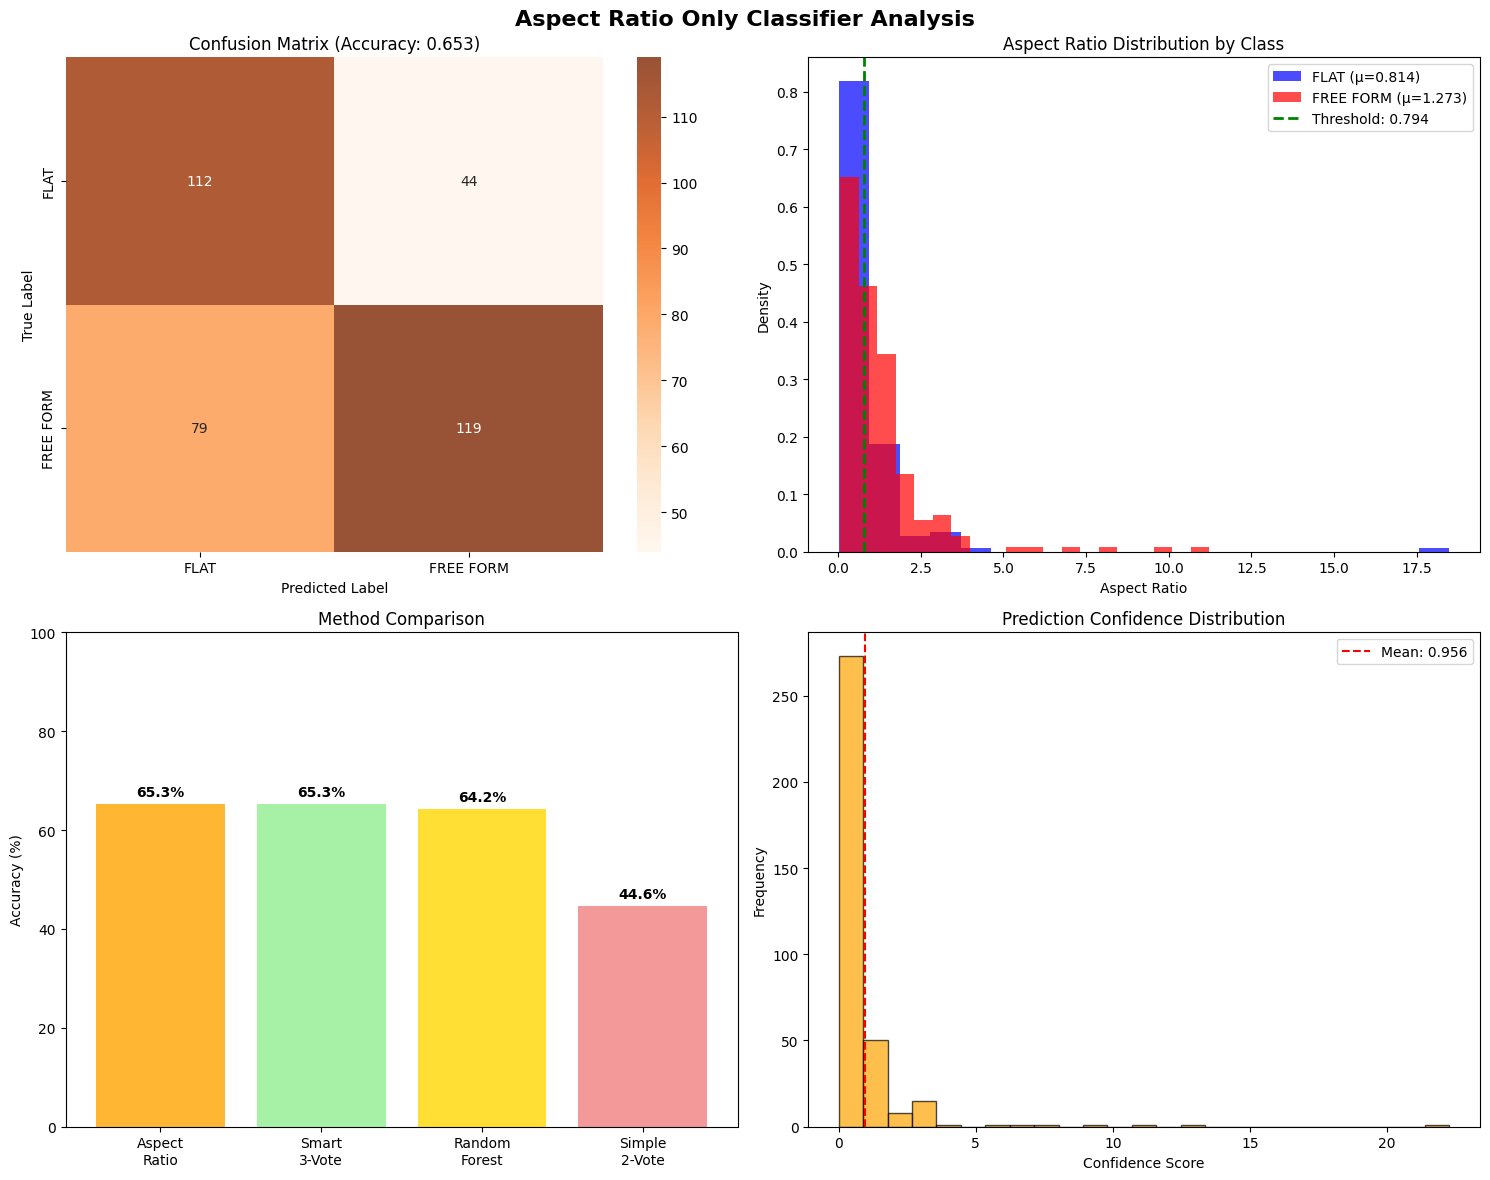


ASPECT RATIO CLASSIFIER EVALUATION COMPLETE!
Single metric achieved 65.3% accuracy
Simple threshold-based classification: aspect_ratio ≤ 0.7945 → FLAT
Demonstrates the power of the best single discriminative feature


In [20]:
# ASPECT RATIO ONLY CLASSIFIER
print("ASPECT RATIO ONLY CLASSIFIER")
print("=" * 50)
print("Using only the best single discriminative metric:")
print("aspect_ratio (68% AUC - best overall single feature)")

# Configuration for aspect_ratio only classifier
aspect_only_config = {
    'metric': 'aspect_ratio',
    'threshold': 0.7945,  # Optimal threshold from ROC analysis
    'direction': 'LOWER_FOR_FLAT'  # Lower aspect_ratio values → FLAT
}

print(f"\nConfiguration:")
print(f"   Metric: {aspect_only_config['metric']}")
print(f"   Threshold: {aspect_only_config['threshold']:.4f}")
print(f"   Rule: Values ≤ {aspect_only_config['threshold']:.4f} → FLAT")
print(f"   Rule: Values > {aspect_only_config['threshold']:.4f} → FREE FORM")

def aspect_ratio_predict(row, config):
    """
    Simple aspect_ratio only classifier
    """
    aspect_value = row[config['metric']]
    threshold = config['threshold']
    
    # Simple threshold-based classification
    if aspect_value <= threshold:
        prediction = 'FLAT'
        confidence = abs(aspect_value - threshold) / threshold
    else:
        prediction = 'FREE FORM'
        confidence = abs(aspect_value - threshold) / threshold
    
    return {
        'prediction': prediction,
        'confidence': confidence,
        'aspect_value': aspect_value,
        'threshold': threshold
    }

print(f"\nTesting aspect_ratio classifier on {len(merged)} samples...")

# Apply aspect_ratio only classification
aspect_results = []
for idx, row in merged.iterrows():
    result = aspect_ratio_predict(row, aspect_only_config)
    result['true_label'] = row['label']
    result['filename'] = row['filename']
    aspect_results.append(result)

# Convert to DataFrame
aspect_df = pd.DataFrame(aspect_results)

# Calculate accuracy
aspect_predictions = aspect_df['prediction'].values
aspect_true_labels = aspect_df['true_label'].values
aspect_accuracy = np.mean(aspect_predictions == aspect_true_labels)

print(f"\nASPECT RATIO CLASSIFIER RESULTS")
print("=" * 50)
print(f"Accuracy: {aspect_accuracy:.4f} ({aspect_accuracy*100:.1f}%)")

# Classification report
print(f"\nClassification Report:")
print(classification_report(aspect_true_labels, aspect_predictions))

# Confusion Matrix
aspect_cm = confusion_matrix(aspect_true_labels, aspect_predictions, labels=['FLAT', 'FREE FORM'])
print(f"\nConfusion Matrix:")
print("             Predicted")
print("           FLAT  FREE FORM")
print(f"Actual FLAT    {aspect_cm[0,0]:4d}       {aspect_cm[0,1]:4d}")
print(f"   FREE FORM   {aspect_cm[1,0]:4d}       {aspect_cm[1,1]:4d}")

# Statistics
aspect_avg_confidence = aspect_df['confidence'].mean()
flat_correct_rate = aspect_cm[0,0] / (aspect_cm[0,0] + aspect_cm[0,1])
freeform_correct_rate = aspect_cm[1,1] / (aspect_cm[1,0] + aspect_cm[1,1])

print(f"\nPerformance Statistics:")
print(f"   Average confidence: {aspect_avg_confidence:.4f}")
print(f"   FLAT detection rate: {flat_correct_rate:.3f} ({flat_correct_rate*100:.1f}%)")
print(f"   FREE FORM detection rate: {freeform_correct_rate:.3f} ({freeform_correct_rate*100:.1f}%)")

# Analyze aspect_ratio distribution
flat_aspect_ratios = aspect_df[aspect_df['true_label'] == 'FLAT']['aspect_value']
freeform_aspect_ratios = aspect_df[aspect_df['true_label'] == 'FREE FORM']['aspect_value']

print(f"\nAspect Ratio Distribution Analysis:")
print(f"   FLAT files - Mean: {flat_aspect_ratios.mean():.4f}, Std: {flat_aspect_ratios.std():.4f}")
print(f"   FREE FORM files - Mean: {freeform_aspect_ratios.mean():.4f}, Std: {freeform_aspect_ratios.std():.4f}")
print(f"   Threshold: {aspect_only_config['threshold']:.4f}")

# Compare with other methods
print(f"\nACCURACY COMPARISON:")
print("-" * 50)
print(f"Aspect Ratio Only:       {aspect_accuracy*100:.1f}% accuracy")
print(f"Smart 3-Vote System:     {smart_accuracy*100:.1f}% accuracy")
print(f"Random Forest:           64.2% accuracy")
print(f"Simple 2-Vote:           {simple_accuracy*100:.1f}% accuracy")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Aspect Ratio Only Classifier Analysis', fontsize=16, fontweight='bold')

# Confusion Matrix
sns.heatmap(aspect_cm, annot=True, fmt='d', cmap='Oranges', alpha=0.8,
            xticklabels=['FLAT', 'FREE FORM'], yticklabels=['FLAT', 'FREE FORM'],
            ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix (Accuracy: {aspect_accuracy:.3f})')
axes[0,0].set_xlabel('Predicted Label')
axes[0,0].set_ylabel('True Label')

# Aspect Ratio Distribution
axes[0,1].hist(flat_aspect_ratios, bins=20, alpha=0.7, color='blue', 
               label=f'FLAT (μ={flat_aspect_ratios.mean():.3f})', density=True)
axes[0,1].hist(freeform_aspect_ratios, bins=20, alpha=0.7, color='red', 
               label=f'FREE FORM (μ={freeform_aspect_ratios.mean():.3f})', density=True)
axes[0,1].axvline(aspect_only_config['threshold'], color='green', linestyle='--', 
                  linewidth=2, label=f'Threshold: {aspect_only_config["threshold"]:.3f}')
axes[0,1].set_xlabel('Aspect Ratio')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Aspect Ratio Distribution by Class')
axes[0,1].legend()

# Accuracy Comparison Bar Chart
methods = ['Aspect\nRatio', 'Smart\n3-Vote', 'Random\nForest', 'Simple\n2-Vote']
accuracies_comp = [aspect_accuracy*100, smart_accuracy*100, 64.2, simple_accuracy*100]
colors_comp = ['orange', 'lightgreen', 'gold', 'lightcoral']
bars = axes[1,0].bar(methods, accuracies_comp, color=colors_comp, alpha=0.8)
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].set_title('Method Comparison')
axes[1,0].set_ylim(0, 100)

# Add accuracy labels
for bar, acc in zip(bars, accuracies_comp):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Confidence Distribution
axes[1,1].hist(aspect_df['confidence'], bins=25, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].axvline(aspect_avg_confidence, color='red', linestyle='--', 
                  label=f'Mean: {aspect_avg_confidence:.3f}')
axes[1,1].set_xlabel('Confidence Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Prediction Confidence Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"\nASPECT RATIO CLASSIFIER EVALUATION COMPLETE!")
print(f"Single metric achieved {aspect_accuracy*100:.1f}% accuracy")
print(f"Simple threshold-based classification: aspect_ratio ≤ {aspect_only_config['threshold']:.4f} → FLAT")
print(f"Demonstrates the power of the best single discriminative feature")